# **Time Series Forecasting**

**[Susan Li](https://actsusanli.medium.com/)** on her article with title "**[An End-to-End Project on Time Series Analysis and Forecasting with Python](https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b)**" said, **Time Series Analysis** comprises methods for analyzing time series data in order to extract meaningful statistics and other characteristics of the data. **Time Series Forecasting** is the use of a model to predict future values based on previously observed values.

**Time Series** are widely used for non-stationary data, like economic, weather, stock price, and retail sales in this post. We will demonstrate different approaches for forecasting retail sales time series.

In [1]:
!pip install sktime[all_extras]

     |████████████████████████████████| 6.7 MB 25.6 MB/s 
     |████████████████████████████████| 9.8 MB 53.2 MB/s 
     |████████████████████████████████| 3.3 MB 59.3 MB/s 
     |████████████████████████████████| 6.9 MB 44.1 MB/s 
     |████████████████████████████████| 136 kB 79.4 MB/s 
     |████████████████████████████████| 97 kB 7.3 MB/s 
     |████████████████████████████████| 580 kB 58.1 MB/s 
     |████████████████████████████████| 1.4 MB 38.2 MB/s 
     |████████████████████████████████| 118 kB 78.3 MB/s 
     |████████████████████████████████| 788 kB 58.1 MB/s 
     |████████████████████████████████| 43 kB 1.4 MB/s 
     |████████████████████████████████| 793 kB 71.9 MB/s 
     |████████████████████████████████| 11.2 MB 60.3 MB/s 
     |████████████████████████████████| 65 kB 3.2 MB/s 
     |████████████████████████████████| 208 kB 45.4 MB/s 
     |████████████████████████████████| 930 kB 43.5 MB/s 
     |████████████████████████████████| 34.5 MB 5.0 kB/s 
     |█████████████

In [1]:
# utilities packages
import datetime

# data wrangling and transformation package
import numpy as np
import pandas as pd
import statsmodels.api as sm

# data visualization package
import matplotlib.pyplot as plt
import seaborn as sns

# time series modeling
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot
from statsmodels.stats.diagnostic import acorr_ljungbox

# load sktime for time series forecasting
from sktime.utils.plotting import plot_series # from plotting
from sktime.forecasting.naive import NaiveForecaster # for naive forecasting
from sktime.forecasting.arima import AutoARIMA # for automated ARIMA forecasting
from sktime.forecasting.exp_smoothing import ExponentialSmoothing # for exponential smoothing forecasting
from sktime.forecasting.ets import AutoETS # for automated ETS forecasting 
from sktime.forecasting.tbats import TBATS # for TBATS forecasting
from sktime.forecasting.fbprophet import Prophet # for Prophet forecasting
from sktime.forecasting.base import ForecastingHorizon # for creating forecast horizon
from sktime.forecasting.model_selection import (
    temporal_train_test_split, 
    ExpandingWindowSplitter, 
    SlidingWindowSplitter
) # for train-test split and cross validation
from sktime.performance_metrics.forecasting import (
    mean_absolute_error, 
    mean_squared_error, 
    mean_absolute_percentage_error
) # for evaluation metrics
from sktime.forecasting.model_evaluation import evaluate # for evaluating CV results

%matplotlib inline

## **Load Dataset**

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/hadimaster65555/dataset_for_teaching/main/dataset/time_series_data/superstore_time_series_dataset/superstore_train.csv")

## **Data Description**

In [3]:
data.head(10)

Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2016-152156  2016-11-08  2016-11-11    Second Class    CG-12520   
1       2  CA-2016-152156  2016-11-08  2016-11-11    Second Class    CG-12520   
2       3  CA-2016-138688  2016-06-12  2016-06-16    Second Class    DV-13045   
3       4  US-2015-108966  2015-10-11  2015-10-18  Standard Class    SO-20335   
4       5  US-2015-108966  2015-10-11  2015-10-18  Standard Class    SO-20335   
5       6  CA-2014-115812  2014-06-09  2014-06-14  Standard Class    BH-11710   
6       7  CA-2014-115812  2014-06-09  2014-06-14  Standard Class    BH-11710   
7       8  CA-2014-115812  2014-06-09  2014-06-14  Standard Class    BH-11710   
8       9  CA-2014-115812  2014-06-09  2014-06-14  Standard Class    BH-11710   
9      10  CA-2014-115812  2014-06-09  2014-06-14  Standard Class    BH-11710   

     Customer Name    Segment        Country             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
5  Brosina Hoffman   Consumer  United States      Los Angeles  ...   
6  Brosina Hoffman   Consumer  United States      Los Angeles  ...   
7  Brosina Hoffman   Consumer  United States      Los Angeles  ...   
8  Brosina Hoffman   Consumer  United States      Los Angeles  ...   
9  Brosina Hoffman   Consumer  United States      Los Angeles  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0       42420   South  FUR-BO-10001798        Furniture    Bookcases   
1       42420   South  FUR-CH-10000454        Furniture       Chairs   
2       90036    West  OFF-LA-10000240  Office Supplies       Labels   
3       33311   South  FUR-TA-10000577        Furniture       Tables   
4       33311   South  OFF-ST-10000760  Office Supplies      Storage   
5       90032    West  FUR-FU-10001487        Furniture  Furnishings   
6       90032    West  OFF-AR-10002833  Office Supplies          Art   
7       90032    West  TEC-PH-10002275       Technology       Phones   
8       90032    West  OFF-BI-10003910  Office Supplies      Binders   
9       90032    West  OFF-AP-10002892  Office Supplies   Appliances   

                                        Product Name     Sales  Quantity  \
0                  Bush Somerset Collection Bookcase  261.9600         2   
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.9400         3   
2  Self-Adhesive Address Labels for Typewriters b...   14.6200         2   
3      Bretford CR4500 Series Slim Rectangular Table  957.5775         5   
4                     Eldon Fold 'N Roll Cart System   22.3680         2   
5  Eldon Expressions Wood and Plastic Desk Access...   48.8600         7   
6                                         Newell 322    7.2800         4   
7                     Mitel 5320 IP Phone VoIP phone  907.1520         6   
8  DXL Angle-View Binders with Locking Rings by S...   18.5040         3   
9                   Belkin F5C206VTEL 6 Outlet Surge  114.9000         5   

   Discount    Profit  
0      0.00   41.9136  
1      0.00  219.5820  
2      0.00    6.8714  
3      0.45 -383.0310  
4      0.20    2.5164  
5      0.00   14.1694  
6      0.00    1.9656  
7      0.20   90.7152  
8      0.20    5.7825  
9      0.00   34.4700  

[10 rows x 21 columns]

**Data Description**

1.   `Row ID` = This is nothing but Serial No.
2.   `Order ID` = ID created when a product order is placed.
3.   `Order Date` = Date on which a customer places his/her order.
4.   `Ship Date` = Date on which the order is shipped.
5.   `Ship Mode` = Mode of shipment of each order.
6.   `Customer ID` - ID assigned to each customer who places an order.
7.   `Customer Name` = Name of Customer.
8.   `Segment` = Section from where the order is placed.
9.   `Country` - Country details of this data set. We are looking only for US store data.
10.   `City` = Cities of US are listed here.
11.   `State` = States of US are listed here.
12.   `Postal Code` = pin code.
13.   `Region` = grouped into region wise.
14.   `Product ID` = Product ID of each product.
15.   `Category` = Category to which each product belongs to.
16.   `Sub-Category` = Sub-Category of each Category
17.   `Product Name` = Name of products.
18.   `Sales` = Selling Price of each product.
19.   `Quantity` = number of quantity available for a particular product.
20.   `Discount` = Discount available on each product.
20.   `Profit` = Profit gained on each product.



In [4]:
# data understanding and profilling
print("*"*8,"Data Understanding & Profilling","*"*8)
print("\n")

# data shape
print("There is", data.shape[0], "observation and", data.shape[1], "columns in this dataset")
print("\n")

# Data Information 
print("Data Info:", data.info())
print("\n")

# Numerical and Categorical Column
num= data.select_dtypes('number').columns
cat = data.select_dtypes('object').columns

print(f'Numerical Columns:  {data[num].columns}')
print('\n')
print(f'Categorical Columns: {data[cat].columns}')
print('\n')

# Statistical Summary of The Data
print("Statistical Description of Data:", data.describe())

******** Data Understanding & Profilling ********


There is 8000 observation and 21 columns in this dataset


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         8000 non-null   int64  
 1   Order ID       8000 non-null   object 
 2   Order Date     8000 non-null   object 
 3   Ship Date      8000 non-null   object 
 4   Ship Mode      8000 non-null   object 
 5   Customer ID    8000 non-null   object 
 6   Customer Name  8000 non-null   object 
 7   Segment        8000 non-null   object 
 8   Country        8000 non-null   object 
 9   City           8000 non-null   object 
 10  State          8000 non-null   object 
 11  Postal Code    8000 non-null   int64  
 12  Region         8000 non-null   object 
 13  Product ID     8000 non-null   object 
 14  Category       8000 non-null   object 
 15  Sub-Category   8000 non-null 

**Unique and Count of Value**

We must know about the unique value of categorical column and count it.

In [5]:
# unique value in dataset
for i in data.columns:
    print(F'{i}:',len(data[i].unique()))

print('\n')

# unique value details
for i in data[cat]:
    print(F'{i}: {data[i].unique()}')

Row ID: 8000
Order ID: 3962
Order Date: 1181
Ship Date: 1279
Ship Mode: 4
Customer ID: 784
Customer Name: 784
Segment: 3
Country: 1
City: 502
State: 49
Postal Code: 598
Region: 4
Product ID: 1831
Category: 3
Sub-Category: 17
Product Name: 1819
Sales: 5186
Quantity: 14
Discount: 12
Profit: 6295


Order ID: ['CA-2016-152156' 'CA-2016-138688' 'US-2015-108966' ... 'US-2015-165743'
 'US-2017-105998' 'US-2014-148194']
Order Date: ['2016-11-08' '2016-06-12' '2015-10-11' ... '2014-05-31' '2014-01-03'
 '2016-07-20']
Ship Date: ['2016-11-11' '2016-06-16' '2015-10-18' ... '2017-07-30' '2016-04-30'
 '2014-05-07']
Ship Mode: ['Second Class' 'Standard Class' 'First Class' 'Same Day']
Customer ID: ['CG-12520' 'DV-13045' 'SO-20335' 'BH-11710' 'AA-10480' 'IM-15070'
 'HP-14815' 'PK-19075' 'AG-10270' 'ZD-21925' 'KB-16585' 'SF-20065'
 'EB-13870' 'EH-13945' 'TB-21520' 'MA-17560' 'GH-14485' 'SN-20710'
 'LC-16930' 'RA-19885' 'ES-14080' 'ON-18715' 'PO-18865' 'LH-16900'
 'DP-13000' 'JM-15265' 'TB-21055' 'KM-16

## **Features Engineering**

### **Features Engineering**

In [6]:
# charge order date column into a datetypes column
data['Order Date'] = pd.to_datetime(data['Order Date'], format='%Y-%m-%d')
data['Ship Date'] = pd.to_datetime(data['Ship Date'], format='%Y-%m-%d')

In [7]:
# define new columns
data['OrderYear'] = data['Order Date'].dt.year
data['OrderMonth'] = data['Order Date'].dt.month
data['MonthYear'] = data.apply(lambda row : (row.OrderMonth,row.OrderYear), axis=1)

In [8]:
data['MonthYear'] = pd.to_datetime(data['MonthYear'], format='(%m, %Y)')

In [10]:
# check data shape
data.shape

(8000, 24)

In [11]:
# rename columns
data.columns = ['RowID','OrderID','OrderDate', 'ShipDate', 'ShipMode', 'CustomerID', 'CustomerName', 'Segment' , 'Country', 'City', 'State', 'PostalCode', 'Region','ProductID','Category','SubCategory','ProductName','Sales','Quantity','Discount','Profit','OrderYear','OrderMonth','MonthYear']

In [12]:
data['PostalCode'] = data['PostalCode'].astype('object')
data['Quantity'] = data['Quantity'].astype('int')

In [13]:
# recheck data type of dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   RowID         8000 non-null   int64         
 1   OrderID       8000 non-null   object        
 2   OrderDate     8000 non-null   datetime64[ns]
 3   ShipDate      8000 non-null   datetime64[ns]
 4   ShipMode      8000 non-null   object        
 5   CustomerID    8000 non-null   object        
 6   CustomerName  8000 non-null   object        
 7   Segment       8000 non-null   object        
 8   Country       8000 non-null   object        
 9   City          8000 non-null   object        
 10  State         8000 non-null   object        
 11  PostalCode    8000 non-null   object        
 12  Region        8000 non-null   object        
 13  ProductID     8000 non-null   object        
 14  Category      8000 non-null   object        
 15  SubCategory   8000 non-null   object  

In [14]:
# drop or delete RowID column
del data['RowID']

In [15]:
# sales column data figures
print('The total variable of Sales are',data['Sales'].count(),'\n')
print('The mean vale of Sales are',data['Sales'].mean(),'\n')
print('The standard deviation of Sales are',data['Sales'].std(),'\n')
print('The minimal of Sales are',data['Sales'].min())

The total variable of Sales are 8000 

The mean vale of Sales are 229.8234590499954 

The standard deviation of Sales are 621.0319272858975 

The minimal of Sales are 0.4439999999999999


### **Data Cleaning**

In [16]:
data.isnull().sum()

OrderID         0
OrderDate       0
ShipDate        0
ShipMode        0
CustomerID      0
CustomerName    0
Segment         0
Country         0
City            0
State           0
PostalCode      0
Region          0
ProductID       0
Category        0
SubCategory     0
ProductName     0
Sales           0
Quantity        0
Discount        0
Profit          0
OrderYear       0
OrderMonth      0
MonthYear       0
dtype: int64

### **Adding Features**

In [17]:
# add GMV column
data['GMV'] = data['Sales'] * data['Quantity']

# add profit or net profit
data['NetProfit'] = (data['Quantity'] * data['Profit']) - (data['Profit'] * data['Quantity'] * data['Discount'])

In [253]:
# create spesific data frame of daily forecasting as daily
daily = data.groupby('OrderDate', as_index=False).agg({
    'OrderID': 'nunique',
    'CustomerID': 'nunique',
    'GMV': 'sum',
    'NetProfit': 'sum'
}).query('GMV > 0')

In [254]:
# Renaming df dataframe
daily = daily.rename(columns={
    'OrderID': "Total TRX",
    'CustomerID': "Total Buyer"
})

In [20]:
# checking daily
daily

OrderDate  Total TRX  Total Buyer         GMV   NetProfit
0    2014-01-03          1            1     32.8960     8.88192
1    2014-01-04          1            1    860.6400  -147.40224
2    2014-01-05          1            1     58.6080    11.72160
3    2014-01-06          3            3  28430.7800  8361.36280
4    2014-01-07          1            1    303.1940   -90.00502
...         ...        ...          ...         ...         ...
1176 2017-12-26          3            3   1731.3740   176.42700
1177 2017-12-27          1            1    381.7680   -31.08264
1178 2017-12-28          9            9   6478.9216  1059.24406
1179 2017-12-29          6            6  14749.8300  3359.71420
1180 2017-12-30          4            4   2584.3020   234.53058

[1181 rows x 5 columns]

In [21]:
# create dataframe groupby year as annual dataframe
year = data.groupby('OrderYear', as_index=False).agg({
    'OrderID': 'nunique',
    'CustomerID': 'nunique',
    'GMV': 'sum',
    'NetProfit': 'sum'
}).query('GMV > 0')

# Renaming
year = year.rename(columns={
    'OrderID': "Total TRX",
    'CustomerID': "Total Buyer"
})

print(year)

   OrderYear  Total TRX  Total Buyer           GMV      NetProfit
0       2014        763          524  2.111150e+06  261722.379219
1       2015        824          504  1.847212e+06  292464.262060
2       2016       1034          577  2.271613e+06  368560.178614
3       2017       1341          642  2.895461e+06  434203.150667


In [22]:
# add total buyer and total transaction column and group by monthyear
month = data.groupby('MonthYear', as_index=False).agg({
    'OrderID': 'nunique',
    'CustomerID': 'nunique',
    'GMV': 'sum',
    'NetProfit': 'sum'
}).query('GMV > 0')

# Renaming
month = month.rename(columns={
    'OrderID': "Total TRX",
    'CustomerID': "Total Buyer"
})


print(month)

    MonthYear  Total TRX  Total Buyer          GMV     NetProfit
0  2014-01-01         27           27   72836.0690  14839.819330
1  2014-02-01         17           17   14661.9720   3001.180260
2  2014-03-01         54           52  267931.6750   7672.313940
3  2014-04-01         51           50  117530.8570  14684.228590
4  2014-05-01         56           55   85920.4770  16619.269880
5  2014-06-01         55           53  149752.2684  22335.965632
6  2014-07-01         51           51  122709.7140  12790.717560
7  2014-08-01         55           54  104200.8055  19954.601425
8  2014-09-01        103           97  348826.6546  39890.112948
9  2014-10-01         61           59  130177.9270  12978.915010
10 2014-11-01        119          112  347378.5822  46068.210474
11 2014-12-01        114          109  349223.2535  50887.044170
12 2015-01-01         23           22   56127.6224  -3176.092668
13 2015-02-01         32           32   49379.3730  10868.937450
14 2015-03-01         66 

In [23]:
# copy data into analytics dataframe
analytic = data[['OrderDate','ShipMode','Segment','Category','SubCategory','Sales','Quantity','Discount','Profit']].copy()

## **Data Visualization**


"The purpose of visualization is insight, not pictures." - Manuel Lima

Data visualization is the practice of converting data from raw figures into a graphical representation such as graphs, maps, charts, and complex dashboards. Let’s see what makes it important (meaning), how it has developed (history), and exactly how it can work in real life (examples). Join us on Data Visualization 101, an introduction to dataviz and its power. (Source: **[Medium of AnyChart](https://medium.com/hackernoon/what-is-data-visualization-definition-history-and-examples-e51ded6e444a)**)

In [24]:
# import packages
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from matplotlib.pylab import rcParams

a_labels = ['Consumer','Corporate Segment','Home Office']
b_labels = ['Office Supply Category','Furniture','Technology']

# create subplots: use 'domain' type for Pie subplot
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=a_labels, values=data['Segment'].value_counts(), name="Segment"),
              1, 1)
fig.add_trace(go.Pie(labels=b_labels, values=data['Category'].value_counts(), name="Category"),
              1, 2)

# use `hole` to create a donut-like pie chart
fig.update_traces(hole=.4, hoverinfo="label+percent+name", textfont_size=16)

fig.update_layout(
    title_text="Segment of Product and Category Product Sales Distributions",
    # add annotations in the center of the donut pies.
    annotations=[dict(text='Segment', x=0.16, y=0.5, font_size=20, showarrow=False),
                 dict(text='Category', x=0.84, y=0.5, font_size=20, showarrow=False)])
fig.show()

In [25]:
labels = data['ShipMode'].unique()
values = data['ShipMode'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_layout(title_text="<b>Shipping Mode Distribution</b>")
fig.show()

In [26]:
labels = data['SubCategory'].unique()
values = data['SubCategory'].value_counts()

fig = go.Figure(data=[go.Pie(labels=labels, values=values, hole=.3)])
fig.update_layout(title_text="<b>Sub-Category Distribution</b>")
fig.show()

## **Exploratory Method for Time Series**

### **Daily**

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Total TRX'>)
None
None


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



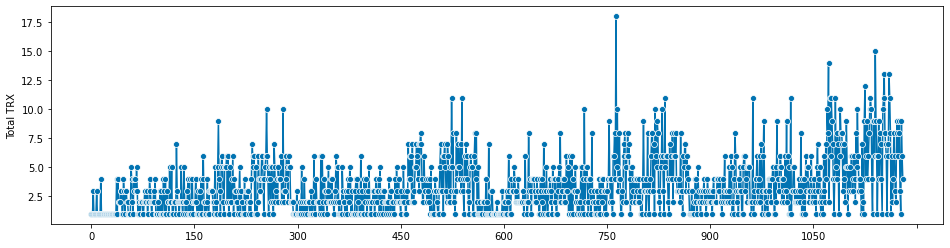

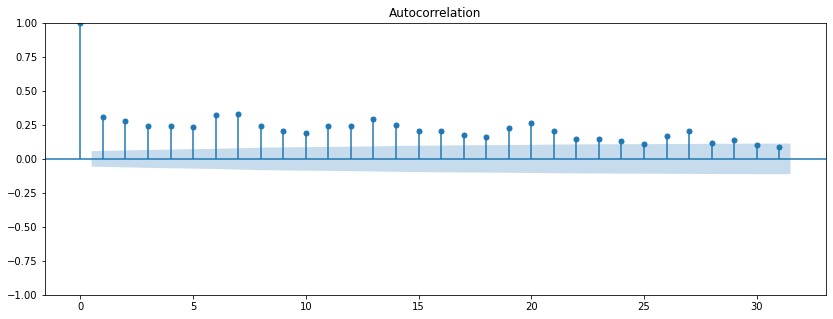

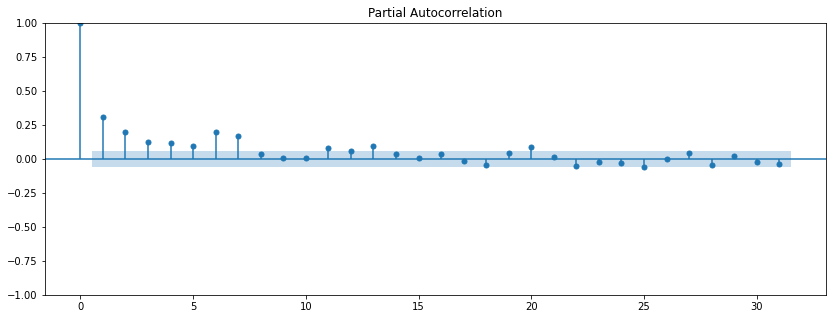

In [27]:
# plot for total transaction
print(plot_series(daily['Total TRX']))
print(plot_acf(daily['Total TRX']).set_size_inches((14,5)))
print(plot_pacf(daily['Total TRX']).set_size_inches((14,5)))

**Interpretation:**

Exploratory on daily total transaction of SuperStore Data and both of **ACF** and **PACF** show slow decay (gradual decrease).

 This situation can be indicated as **Auto-Regressive Integrated Moving Average Model** ***`ARMA (1,1)`***.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Total Buyer'>)
None
None


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



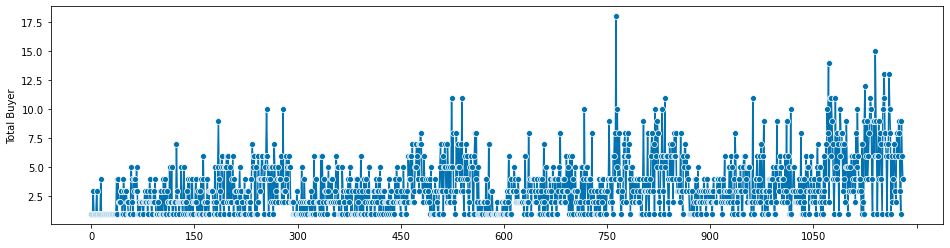

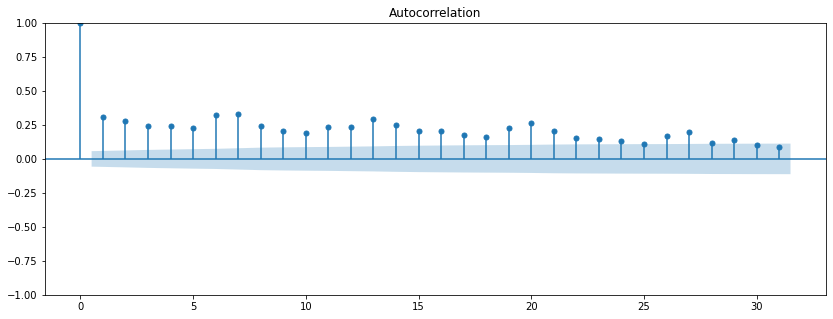

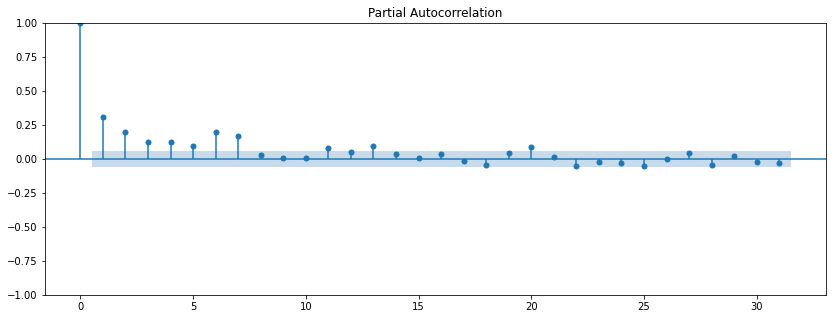

In [28]:
# plot for total buyer
print(plot_series(daily['Total Buyer']))
print(plot_acf(daily['Total Buyer']).set_size_inches((14,5)))
print(plot_pacf(daily['Total Buyer']).set_size_inches((14,5)))

**Interpretation:**

Exploratory on daily total buyer or customer rate of SuperStore Data and both of **ACF** and **PACF** show slow decay (gradual decrease).

This situation can be indicated as **Auto-Regressive Moving Average Model** ***`ARMA (1,1)`***.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='GMV'>)
None
None


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



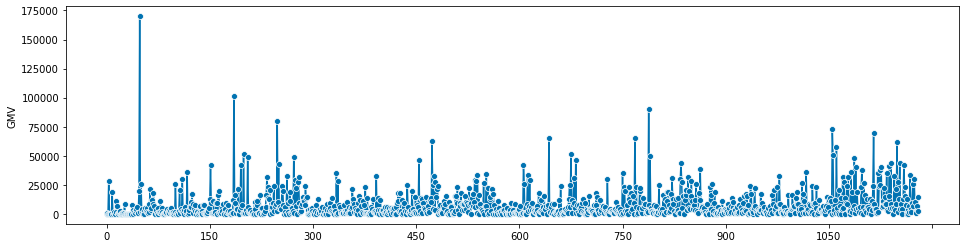

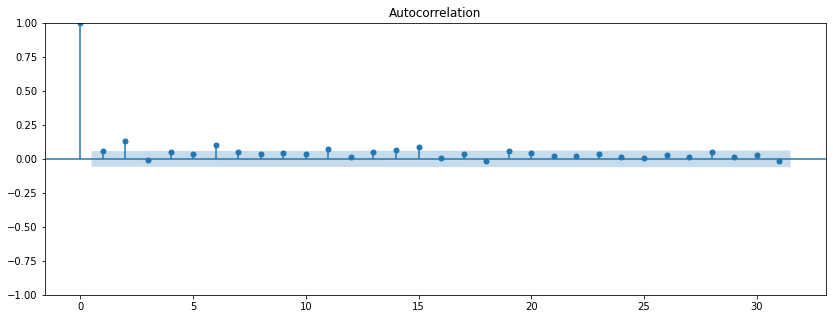

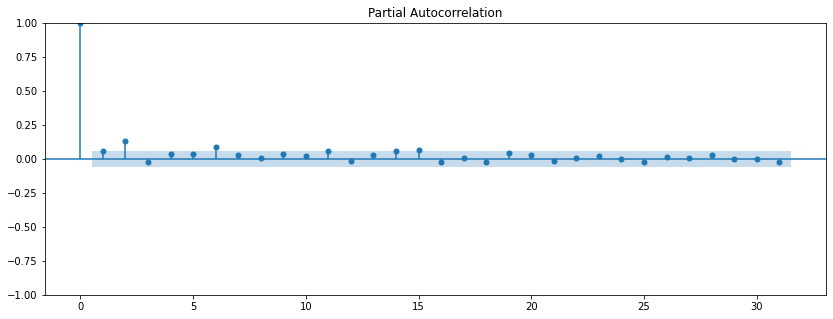

In [29]:
# plot for gmv
print(plot_series(daily['GMV']))
print(plot_acf(daily['GMV']).set_size_inches((14,5)))
print(plot_pacf(daily['GMV']).set_size_inches((14,5)))

**Interpretation:**

Exploratory on daily GMV or Gross Merchandise Value of SuperStore Data and both of **ACF** and **PACF** show slow decay (gradual decrease).

This situation can be indicated as **Auto-Regressive Moving Average Model** ***`ARMA (2,2)`***.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='NetProfit'>)
None
None


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



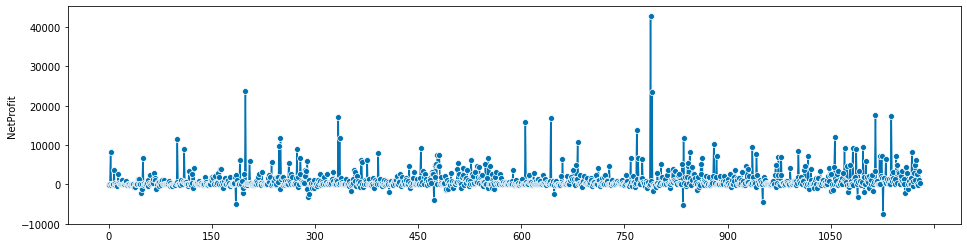

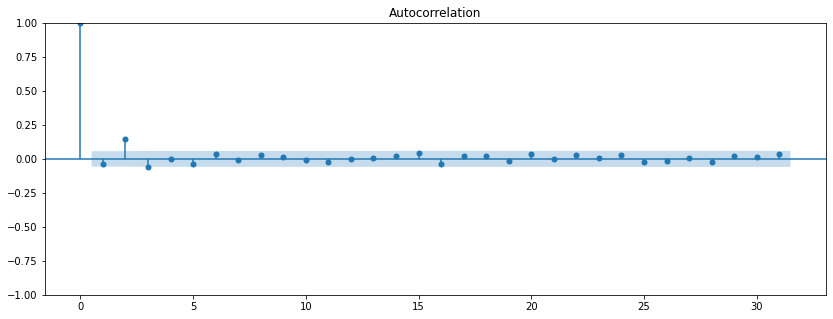

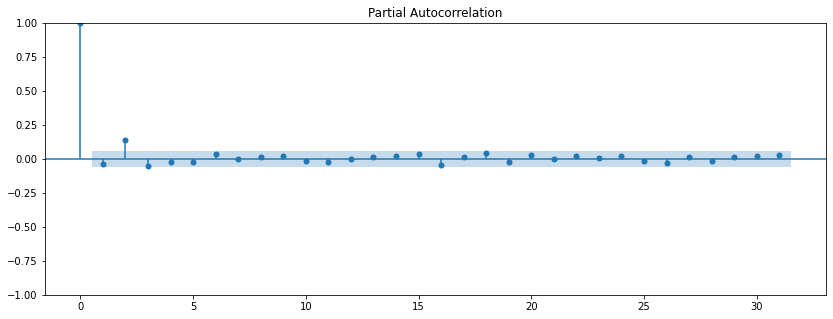

In [30]:
# plot for net profit
print(plot_series(daily['NetProfit']))
print(plot_acf(daily['NetProfit']).set_size_inches((14,5)))
print(plot_pacf(daily['NetProfit']).set_size_inches((14,5)))

**Interpretation:**

Exploratory on total Net Profit of each day of SuperStore Data indicated as ***`White Noise`***.

### **Monthly**

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Total TRX'>)
None
None


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



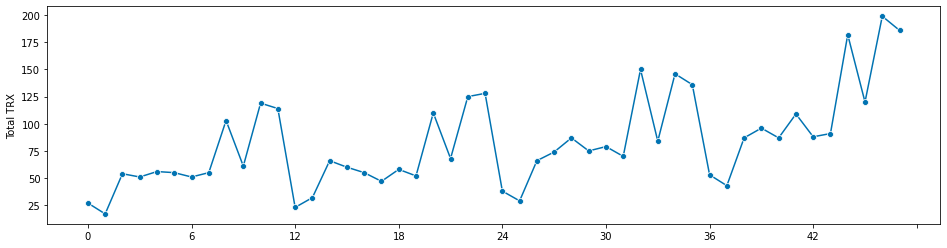

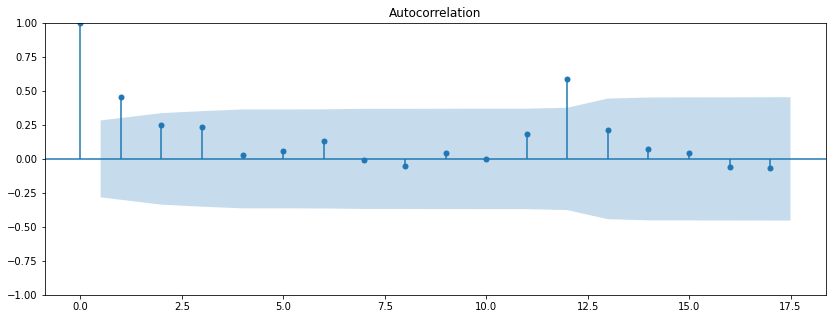

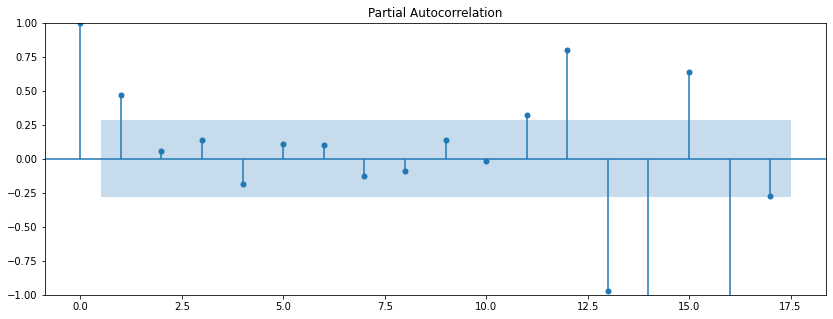

In [31]:
# plot for total transaction
print(plot_series(month['Total TRX']))
print(plot_acf(month['Total TRX']).set_size_inches((14,5)))
print(plot_pacf(month['Total TRX']).set_size_inches((14,5)))

**Interpretation:**

Exploratory on monthly total transaction of SuperStore Data indicated as **Auto-Regressive (1) Model** ***`(AR 1)`***.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Total Buyer'>)
None
None


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



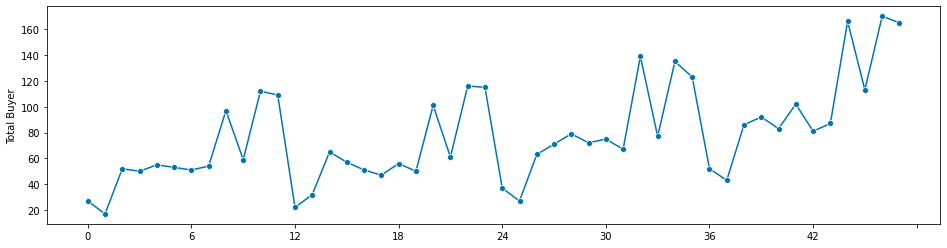

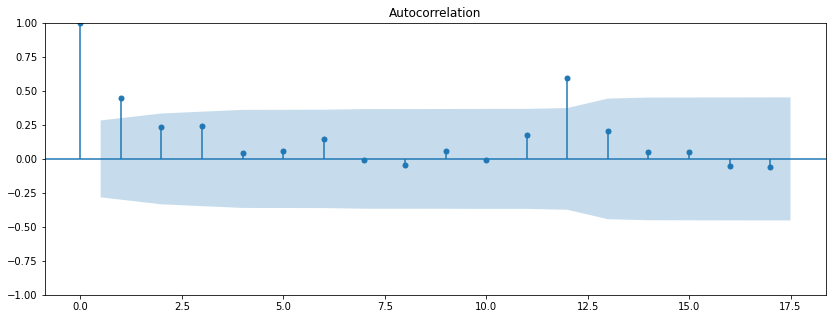

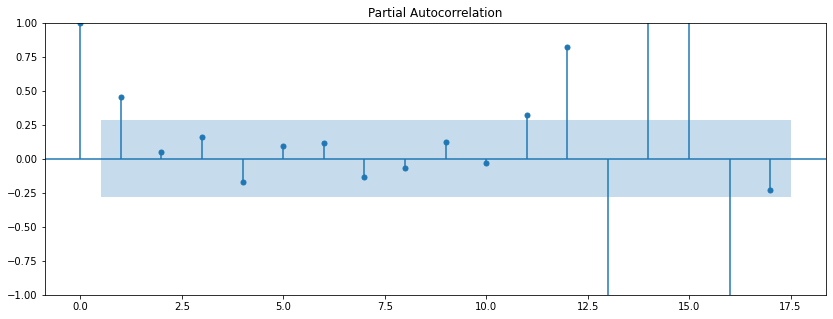

In [32]:
# plot for total buyer
print(plot_series(month['Total Buyer']))
print(plot_acf(month['Total Buyer']).set_size_inches((14,5)))
print(plot_pacf(month['Total Buyer']).set_size_inches((14,5)))

**Interpretation:**

Exploratory on monthly total buyer of SuperStore Data indicated as **Auto-Regressive (1) Model** ***`(AR 1)`***.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='GMV'>)
None
None


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



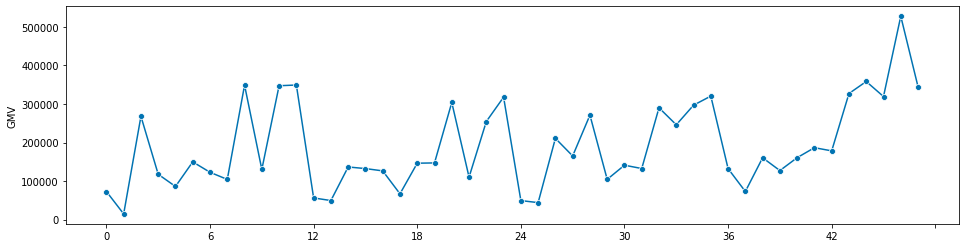

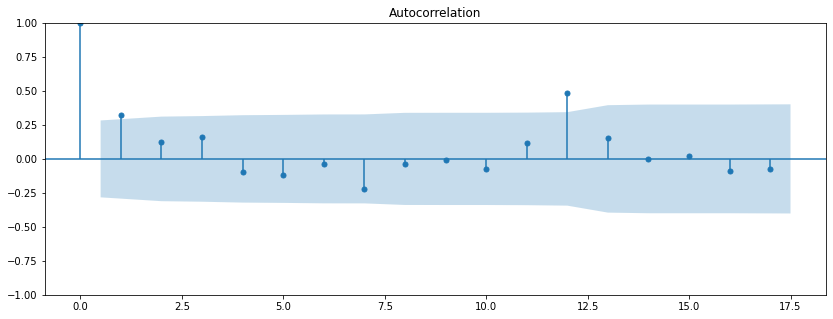

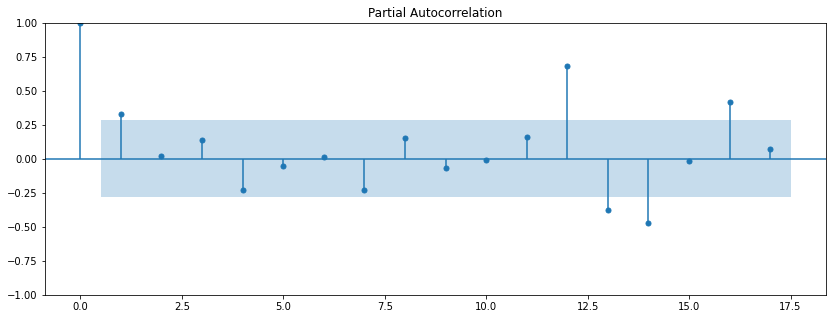

In [33]:
# plot for gmv
print(plot_series(month['GMV']))
print(plot_acf(month['GMV']).set_size_inches((14,5)))
print(plot_pacf(month['GMV']).set_size_inches((14,5)))

**Interpretation:**

Exploratory on monthly GMV or Gross Merchandise Value of SuperStore Data indicated as **Auto-Regressive (1) Model** ***`(AR 1)`***.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='NetProfit'>)
None
None


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



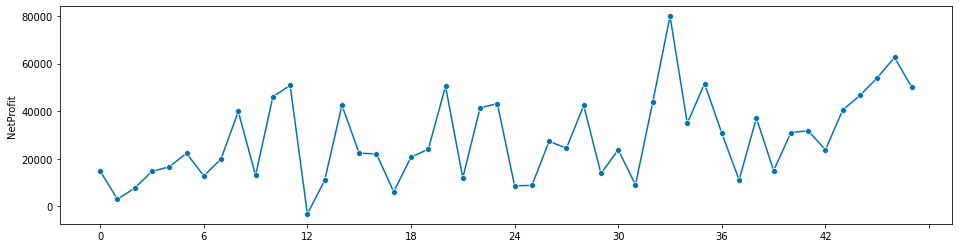

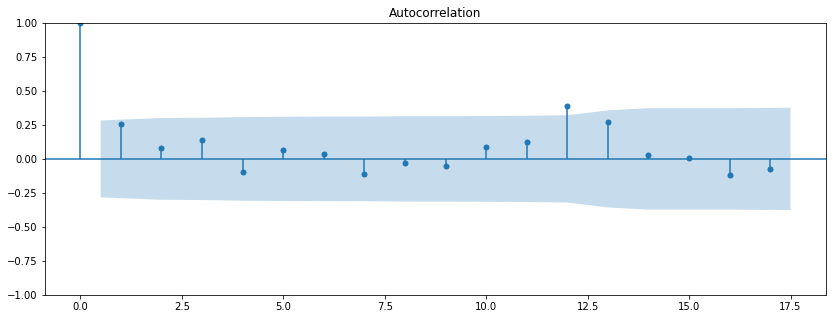

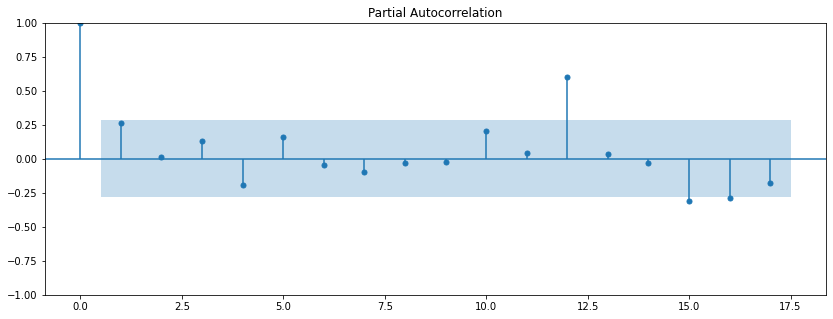

In [34]:
# plot for net profit
print(plot_series(month['NetProfit']))
print(plot_acf(month['NetProfit']).set_size_inches((14,5)))
print(plot_pacf(month['NetProfit']).set_size_inches((14,5)))

**Interpretation:**

Exploratory on monthly Net Profit of SuperStore Data and and both of **ACF** and **PACF** show slow decay (gradual decrease).

 indicated as **Auto-Regressive Moving Average(1) Model** ***`ARMA (1,1)`***.

### **Annual**

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Total TRX'>)
Figure(432x288)


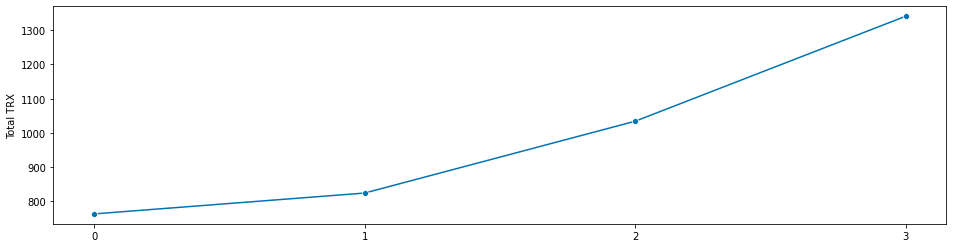

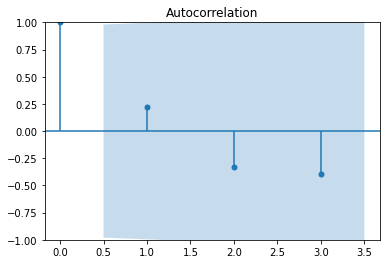

In [35]:
# plot for total transaction
print(plot_series(year['Total TRX']))
print(plot_acf(year['Total TRX']))

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Total Buyer'>)
Figure(432x288)


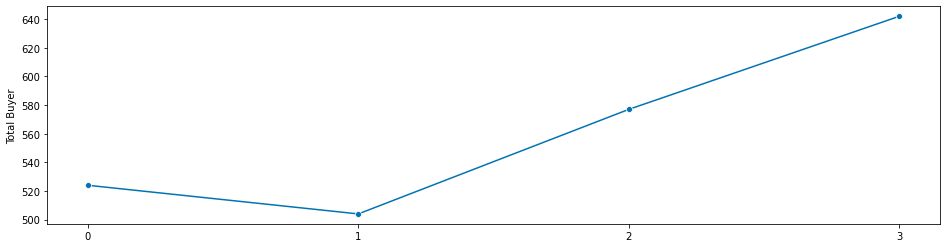

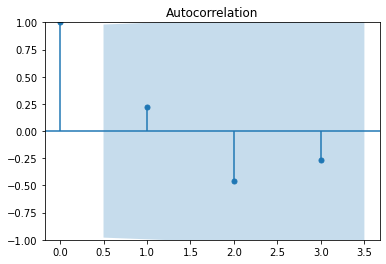

In [36]:
# plot for total buyer
print(plot_series(year['Total Buyer']))
print(plot_acf(year['Total Buyer']))

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='GMV'>)
Figure(432x288)


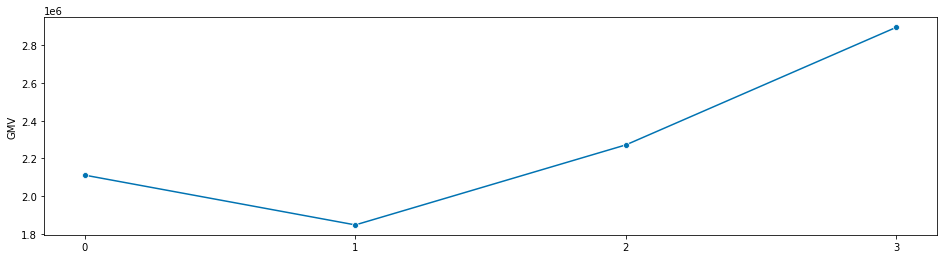

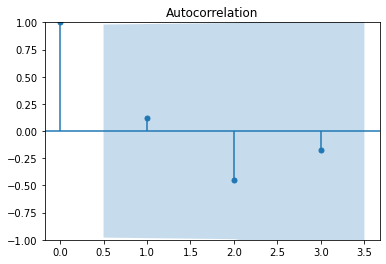

In [37]:
# plot for gmv
print(plot_series(year['GMV']))
print(plot_acf(year['GMV']))

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='NetProfit'>)
Figure(432x288)


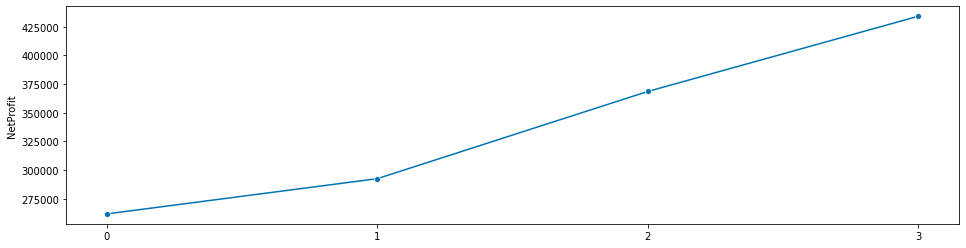

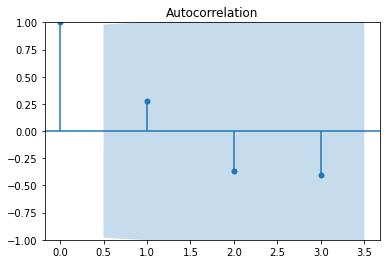

In [38]:
# plot for net profit
print(plot_series(year['NetProfit']))
print(plot_acf(year['NetProfit']))

**Interpretation:**

Exploratory on annual total transaction, total buyer, GMV and Net Profit of SuperStore Data only can do on **ACF** and it show ***`White Noise`***.

### **Monthly Retention**

In [39]:
monthly_retention = data[['OrderID','CustomerID','OrderDate']].copy()

In [40]:
monthly_retention['OrderMonth'] = monthly_retention['OrderDate'].dt.to_period('M')
monthly_retention['Cohort'] = monthly_retention.groupby('CustomerID')['OrderDate'] \
                 .transform('min') \
                 .dt.to_period('M')

In [41]:
monthly_retention

OrderID CustomerID  OrderDate OrderMonth   Cohort
0     CA-2016-152156   CG-12520 2016-11-08    2016-11  2015-10
1     CA-2016-152156   CG-12520 2016-11-08    2016-11  2015-10
2     CA-2016-138688   DV-13045 2016-06-12    2016-06  2016-06
3     US-2015-108966   SO-20335 2015-10-11    2015-10  2015-10
4     US-2015-108966   SO-20335 2015-10-11    2015-10  2015-10
...              ...        ...        ...        ...      ...
7995  US-2015-165743   MM-18055 2015-11-20    2015-11  2014-05
7996  US-2017-105998   CR-12580 2017-11-03    2017-11  2016-04
7997  US-2017-105998   CR-12580 2017-11-03    2017-11  2016-04
7998  US-2014-148194   BS-11365 2014-05-04    2014-05  2014-05
7999  US-2014-148194   BS-11365 2014-05-04    2014-05  2014-05

[8000 rows x 5 columns]

In [42]:
monthly_retention.columns = monthly_retention.columns.str.strip()

In [43]:
from operator import attrgetter
cohort_data = monthly_retention.groupby(['Cohort','OrderMonth']).agg(n_customers=('CustomerID', 'nunique')).reset_index(drop=False)
cohort_data['PeriodNumber'] = (cohort_data.OrderMonth - cohort_data.Cohort).apply(attrgetter('n'))

In [44]:
cohort_pivot = cohort_data.pivot_table(index = 'Cohort',
                                     columns = 'PeriodNumber',
                                     values = 'n_customers')

In [45]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

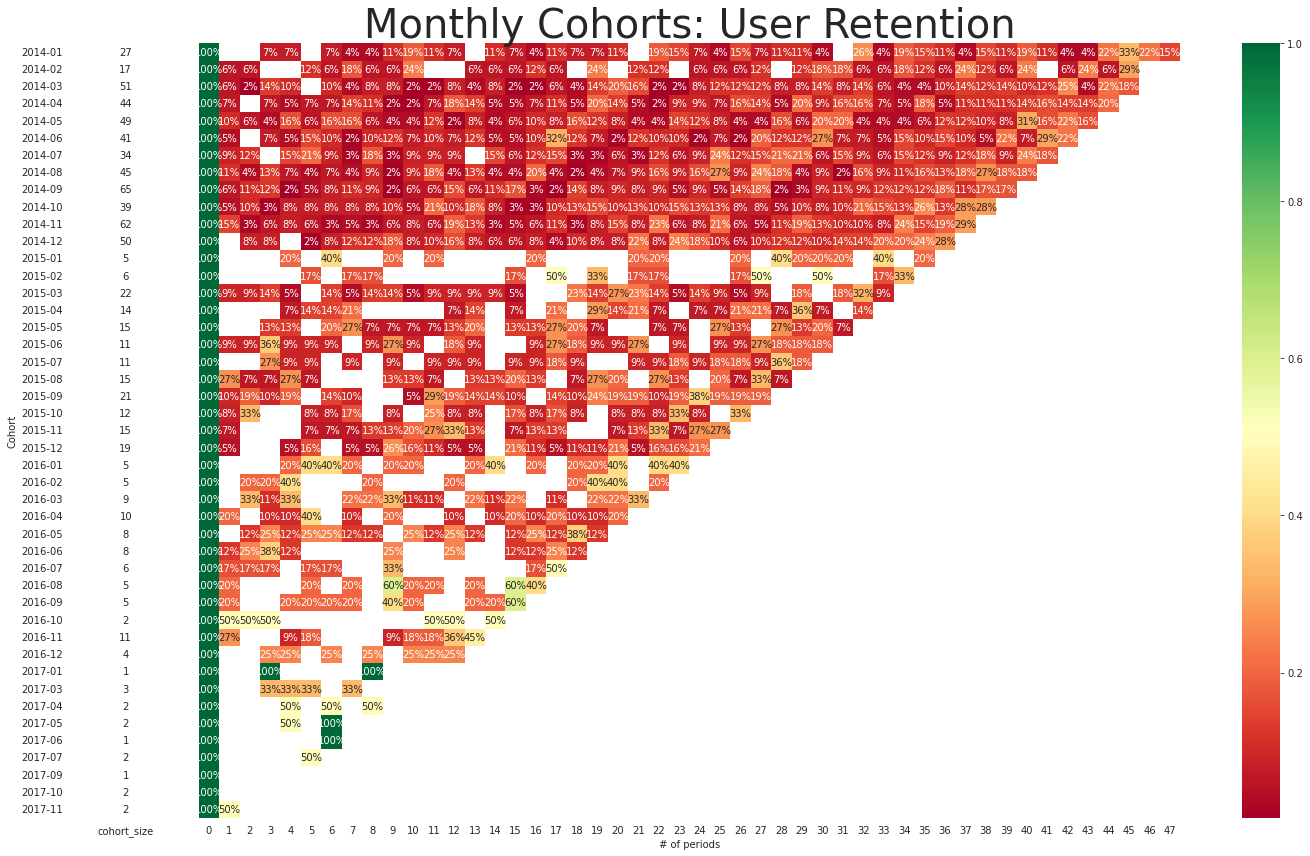

In [46]:
import matplotlib.colors as mcolors

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(20, 12), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=40)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

**Interpretation**

Based on **Cohort Analysis**, not too many customers make repeat purchases in a monthly period. With a percentage of less than 20%

## Analysis of Store Profit

In [47]:
analytic.head(10)

OrderDate        ShipMode    Segment         Category  SubCategory  \
0 2016-11-08    Second Class   Consumer        Furniture    Bookcases   
1 2016-11-08    Second Class   Consumer        Furniture       Chairs   
2 2016-06-12    Second Class  Corporate  Office Supplies       Labels   
3 2015-10-11  Standard Class   Consumer        Furniture       Tables   
4 2015-10-11  Standard Class   Consumer  Office Supplies      Storage   
5 2014-06-09  Standard Class   Consumer        Furniture  Furnishings   
6 2014-06-09  Standard Class   Consumer  Office Supplies          Art   
7 2014-06-09  Standard Class   Consumer       Technology       Phones   
8 2014-06-09  Standard Class   Consumer  Office Supplies      Binders   
9 2014-06-09  Standard Class   Consumer  Office Supplies   Appliances   

      Sales  Quantity  Discount    Profit  
0  261.9600         2      0.00   41.9136  
1  731.9400         3      0.00  219.5820  
2   14.6200         2      0.00    6.8714  
3  957.5775         5      0.45 -383.0310  
4   22.3680         2      0.20    2.5164  
5   48.8600         7      0.00   14.1694  
6    7.2800         4      0.00    1.9656  
7  907.1520         6      0.20   90.7152  
8   18.5040         3      0.20    5.7825  
9  114.9000         5      0.00   34.4700

In [48]:
# dataframe description
print("*"*8,"Analytic Data Understanding & Profilling","*"*8)
print("\n")

# data shape
print("There is", analytic.shape[0], "observation and", analytic.shape[1], "columns in this dataset")
print("\n")

# Data Information 
print("Data Info:", analytic.info())
print("\n")

# Numerical and Categorical Column
numerical = analytic.select_dtypes('number').columns
category = analytic.select_dtypes('object').columns

print(f'Numerical Columns:  {analytic[numerical].columns}')
print('\n')
print(f'Categorical Columns: {analytic[category].columns}')
print('\n')

# Statistical Summary of The Data
print("Statistical Description of Data:", analytic.describe())

******** Analytic Data Understanding & Profilling ********


There is 8000 observation and 9 columns in this dataset


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   OrderDate    8000 non-null   datetime64[ns]
 1   ShipMode     8000 non-null   object        
 2   Segment      8000 non-null   object        
 3   Category     8000 non-null   object        
 4   SubCategory  8000 non-null   object        
 5   Sales        8000 non-null   float64       
 6   Quantity     8000 non-null   int64         
 7   Discount     8000 non-null   float64       
 8   Profit       8000 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 562.6+ KB
Data Info: None


Numerical Columns:  Index(['Sales', 'Quantity', 'Discount', 'Profit'], dtype='object')


Categorical Columns: Index(['ShipMode', 'Segme

In [49]:
# filter last 3 month sales
analytic = analytic.loc[(analytic['OrderDate'] >= '2017-10-01') & (analytic['OrderDate'] < '2017-12-31')]

### **Data Analytic Visualization**

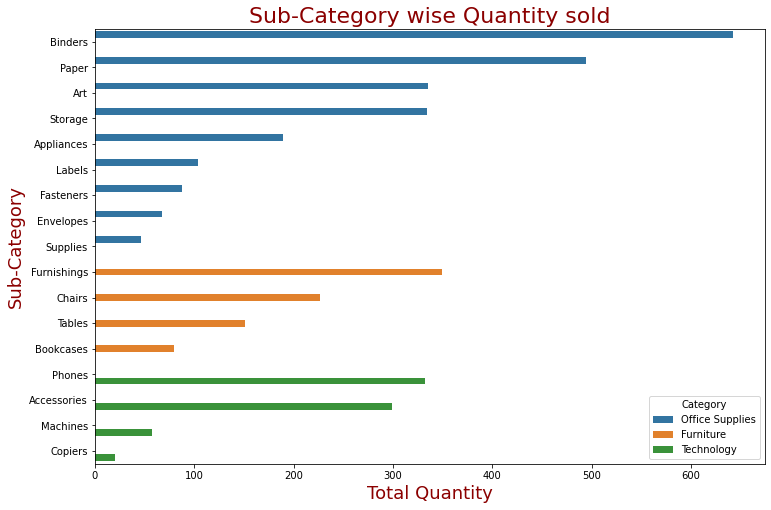

In [50]:
# sub-category solds quantity
quant_cat_sub = analytic.groupby(['Category','SubCategory']).Quantity.sum().reset_index().sort_values(by=['Category','Quantity'], ascending=[True,False], key=lambda x : x.replace({'Office Supplies':1,'Furniture':2,'Technology':3}))
plt.figure(figsize=(12,8))
sns.barplot(data=quant_cat_sub,y='SubCategory',x='Quantity',hue='Category')
plt.title('Sub-Category wise Quantity sold',fontdict={'fontsize':22,'family':'sans serif','color':'darkred'})
plt.xlabel('Total Quantity',fontdict={'fontsize':18,'family':'sans serif','color':'darkred'})
plt.ylabel('Sub-Category',fontdict={'fontsize':18,'family':'sans serif','color':'darkred'})
plt.show()

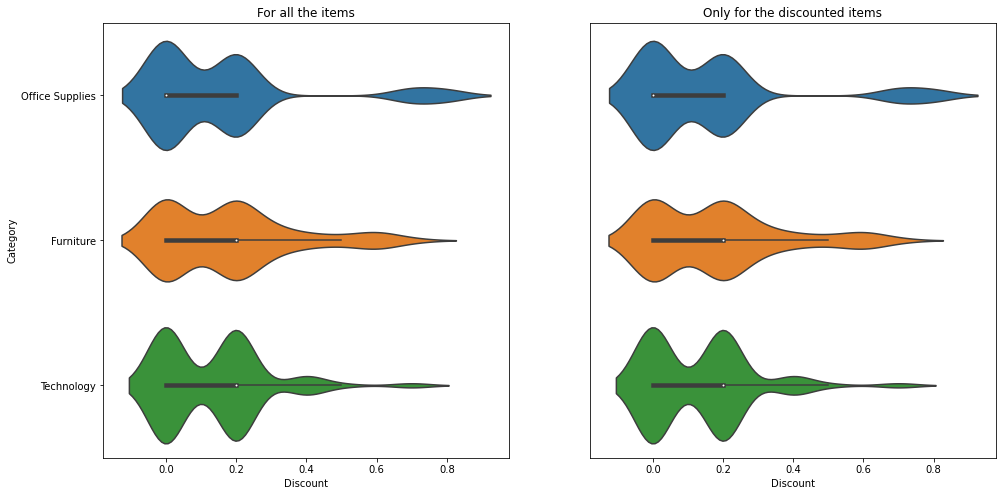

In [51]:
# discount of item
plt.figure(figsize=(16,8))
ax1, ax2 = plt.subplot(1,2,1), plt.subplot(1,2,2)

sns.violinplot(data=analytic,x='Discount',y='Category',inner='box',ax=ax1)
ax1.set_title('For all the items')
sns.violinplot(data=analytic,x='Discount',y='Category',inner='box',ax=ax2,sharex=ax1)
ax2.set_title('Only for the discounted items')
ax2.set_yticks([])
ax2.set_ylabel('')

plt.show()

### **Data Preprocessing**

In [52]:
# get dummies
analytic_dummies = pd.get_dummies(analytic)
analytic_dummies.head(10)

OrderDate    Sales  Quantity  Discount   Profit  ShipMode_First Class  \
34  2017-10-19   29.472         3       0.2   9.9468                     0   
75  2017-12-09    1.248         3       0.8  -1.9344                     1   
76  2017-12-09    9.708         3       0.6  -5.8248                     1   
77  2017-12-09   27.240         3       0.2   2.7240                     1   
84  2017-11-13  230.376         3       0.2 -48.9549                     1   
86  2017-10-26   19.990         1       0.0   6.7966                     0   
87  2017-10-26    6.160         2       0.0   2.9568                     0   
95  2017-11-06    5.682         1       0.7  -3.7880                     0   
96  2017-11-09   96.530         7       0.0  40.5426                     0   
106 2017-11-23   74.112         8       0.2  17.6016                     0   

     ShipMode_Same Day  ShipMode_Second Class  ShipMode_Standard Class  \
34                   0                      1                        0   
75                   0                      0                        0   
76                   0                      0                        0   
77                   0                      0                        0   
84                   0                      0                        0   
86                   0                      0                        1   
87                   0                      0                        1   
95                   0                      0                        1   
96                   0                      1                        0   
106                  0                      0                        1   

     Segment_Consumer  ...  SubCategory_Envelopes  SubCategory_Fasteners  \
34                  0  ...                      0                      0   
75                  0  ...                      0                      0   
76                  0  ...                      0                      0   
77                  0  ...                      0                      0   
84                  0  ...                      0                      0   
86                  1  ...                      0                      0   
87                  1  ...                      0                      0   
95                  0  ...                      0                      0   
96                  0  ...                      0                      0   
106                 1  ...                      0                      0   

     SubCategory_Furnishings  SubCategory_Labels  SubCategory_Machines  \
34                         0                   0                     0   
75                         0                   0                     0   
76                         1                   0                     0   
77                         0                   0                     0   
84                         0                   0                     0   
86                         0                   0                     0   
87                         0                   1                     0   
95                         0                   0                     0   
96                         1                   0                     0   
106                        0                   0                     0   

     SubCategory_Paper  SubCategory_Phones  SubCategory_Storage  \
34                   1                   0                    0   
75                   0                   0                    0   
76                   0                   0                    0   
77                   0                   0                    1   
84                   0                   0                    1   
86                   0                   0                    0   
87                   0                   0                    0   
95                   0                   0                    0   
96                   0                   0                    0   
106      

In [53]:
# recheck data shape
analytic_dummies.shape

(985, 32)

In [54]:
# deleting a column that causes a bias and misreading
del analytic_dummies['Quantity']
del analytic_dummies['Sales']
del analytic_dummies['OrderDate']

In [72]:
# import library
from sklearn.model_selection import train_test_split

# create predictor variables as X
X = analytic_dummies.drop(['Profit'], axis = 1)
# create target data as y
y = analytic_dummies['Profit']

# split data to train and test data
# where 25% of data are test data
# stratify data based on y varibales
# and freeze RNG with random_state = 1000
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    test_size=0.25,
    )

In [56]:
# check train data dimension
print('the size of train predictor are:',X_train.shape,'\n')

# check test data dimension
print('the size of test predictor are:',X_test.shape,'\n')

# check train target counts
print('the value count of target on train set is: ','\n',y_train.value_counts(),'\n')

# check test target counts
print('the value count of target on test set is:','\n',y_test.value_counts(),'\n')

the size of train predictor are: (738, 28) 

the size of test predictor are: (247, 28) 

the value count of target on train set is:  
 0.0000     7
6.2208     4
5.4432     3
7.2576     3
9.3312     3
          ..
10.5084    1
22.0032    1
7.6272     1
5.6994     1
1.5876     1
Name: Profit, Length: 710, dtype: int64 

the value count of target on test set is: 
 3.6288     3
1.7901     2
6.2208     2
9.3312     2
0.9995     1
          ..
3.6632     1
3.6796     1
24.7275    1
66.9546    1
4.2392     1
Name: Profit, Length: 242, dtype: int64 



### **EDA of Train Data**

In [57]:
# pre-proccessing (simple) analysis on data
plt.figure(figsize=(14,7))
analytic_dummies.corr()['Profit'].sort_values(ascending = False)

Profit                      1.000000
SubCategory_Copiers         0.498189
Category_Technology         0.117065
Segment_Home Office         0.041266
SubCategory_Phones          0.036316
SubCategory_Accessories     0.026228
SubCategory_Appliances      0.024979
SubCategory_Chairs          0.021750
ShipMode_First Class        0.021073
ShipMode_Second Class       0.016151
SubCategory_Storage         0.011838
Segment_Consumer            0.006631
SubCategory_Paper           0.003168
SubCategory_Envelopes       0.001261
ShipMode_Standard Class     0.000521
SubCategory_Labels         -0.005844
SubCategory_Supplies       -0.007504
SubCategory_Fasteners      -0.008303
SubCategory_Furnishings    -0.016324
SubCategory_Art            -0.016348
SubCategory_Bookcases      -0.033691
Segment_Corporate          -0.042933
Category_Furniture         -0.049147
Category_Office Supplies   -0.050452
ShipMode_Same Day          -0.063960
SubCategory_Binders        -0.076128
SubCategory_Tables         -0.083026
S

<Figure size 1008x504 with 0 Axes>

**Interpretation**

From correlation of all features, **`Copiers`** from **`Technology`** Category give the largest effect on profit. Otherwise, **`Discount`** and **`Tables`** from **`Furniture`** category give less effect on profit.

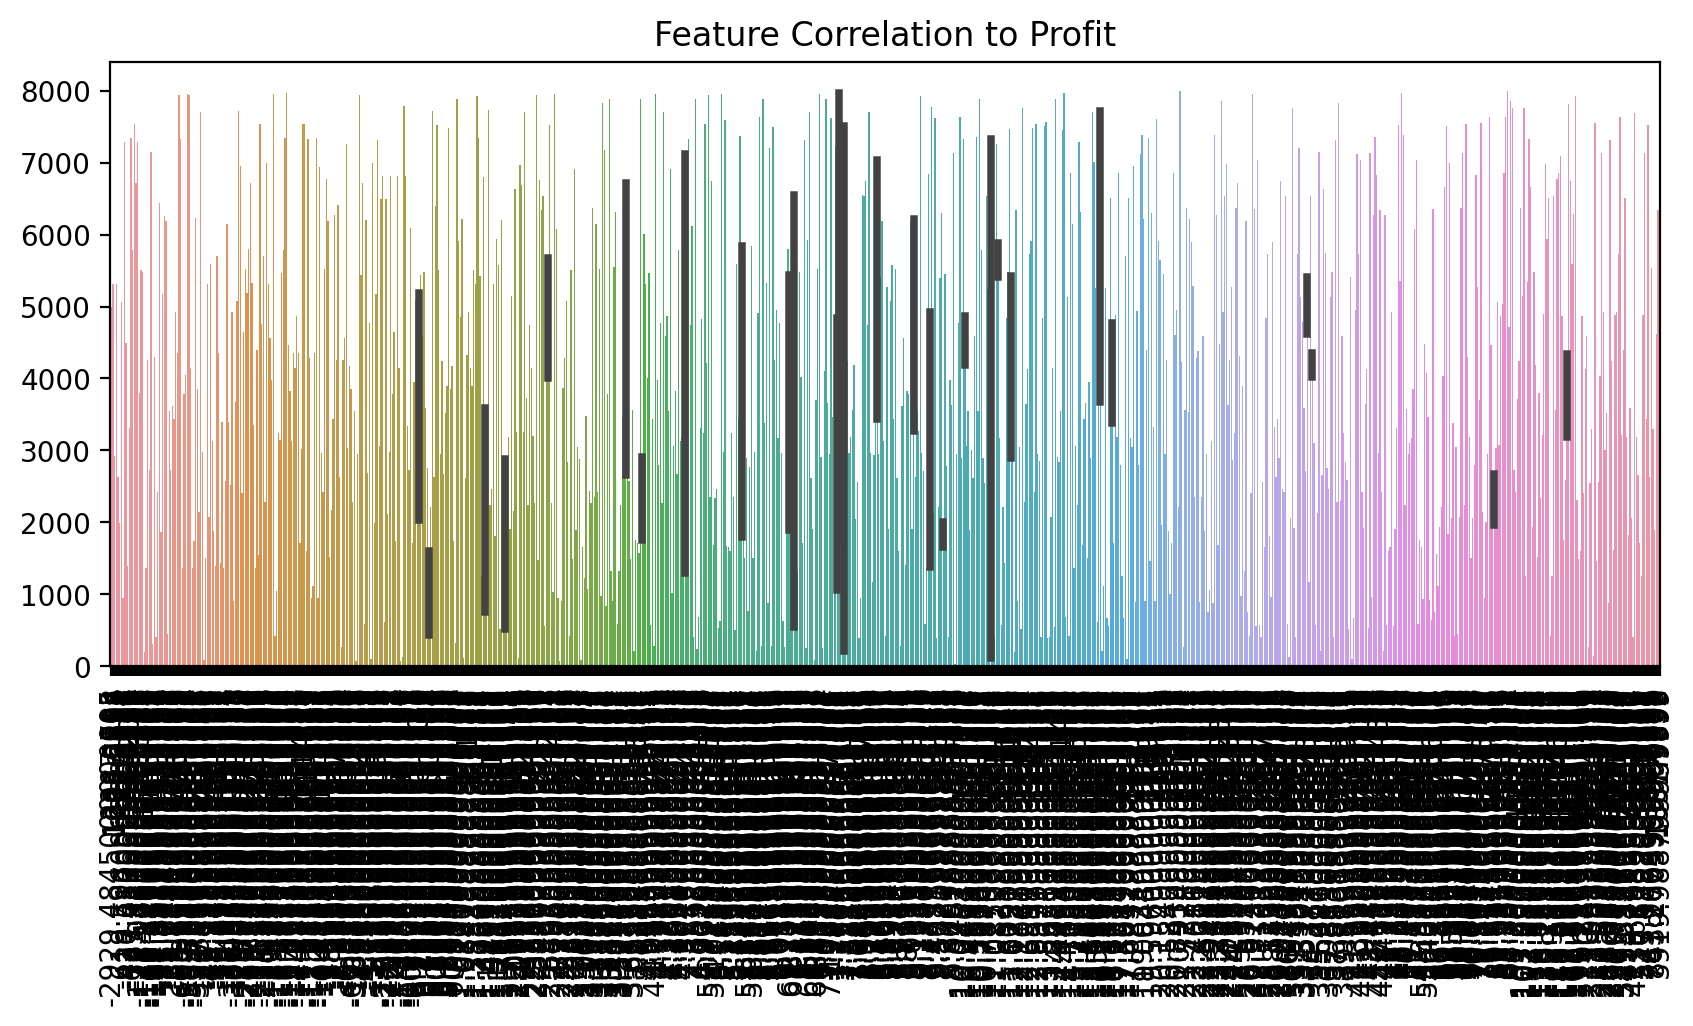

In [58]:
plt.figure(figsize=(10,4),dpi=200)
sns.barplot(x=analytic_dummies['Profit'].sort_values().iloc[1:-1].values,y=analytic_dummies['Profit'].sort_values().iloc[1:-1].index)
plt.title("Feature Correlation to Profit")
plt.xticks(rotation=90);

### **Modeling**

In [59]:
# import package
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.metrics import r2_score

In [73]:
# model
clf1 = LinearRegression()
clf2 = Ridge()
clf3 = Lasso()
clf4 = DecisionTreeRegressor()
clf5 = RandomForestRegressor()
clf6 = KNeighborsRegressor()
clf7 = SVR(kernel="poly")
clf8 = AdaBoostRegressor()
clf9 = XGBRegressor()

In [74]:
# import package for search the best param
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

#### Model Train

##### Linear Regression

In [75]:
# linear regression
clf1.fit(X_train,y_train)

# pred test
y_pred_test1 = clf1.predict(X_test)
y_pred1 = pd.DataFrame(y_pred_test1)
MAE_li_reg= metrics.mean_absolute_error(y_test, y_pred1)
MSE_li_reg = metrics.mean_squared_error(y_test, y_pred1)
RMSE_li_reg =np.sqrt(MSE_li_reg)
R2_Score = r2_score(y_test,y_pred1)
pd.DataFrame([MAE_li_reg, MSE_li_reg, RMSE_li_reg,R2_Score], index=['MAE_li_reg', 'MSE_li_reg', 'RMSE_li_reg','R2 Score'], columns=['Metrics'])

Metrics
MAE_li_reg      79.436168
MSE_li_reg   36951.781664
RMSE_li_reg    192.228462
R2 Score        -0.704716

##### Ridge Regression

In [76]:
# ridge
clf2.fit(X_train,y_train)

# pred test
y_pred_test2 = clf2.predict(X_test)
y_pred2 = pd.DataFrame(y_pred_test2)
MAE_li_reg= metrics.mean_absolute_error(y_test, y_pred2)
MSE_li_reg = metrics.mean_squared_error(y_test, y_pred2)
RMSE_li_reg =np.sqrt(MSE_li_reg)
R2_Score = r2_score(y_test,y_pred2)
pd.DataFrame([MAE_li_reg, MSE_li_reg, RMSE_li_reg,R2_Score], index=['MAE_li_reg', 'MSE_li_reg', 'RMSE_li_reg','R2 Score'], columns=['Metrics'])

Metrics
MAE_li_reg      77.791352
MSE_li_reg   31887.315425
RMSE_li_reg    178.570197
R2 Score        -0.471075

##### Lasso Regression

In [77]:
# lasso
clf3.fit(X_train,y_train)

# pred test
y_pred_test3 = clf3.predict(X_test)
y_pred3 = pd.DataFrame(y_pred_test3)
MAE_li_reg= metrics.mean_absolute_error(y_test, y_pred3)
MSE_li_reg = metrics.mean_squared_error(y_test, y_pred3)
RMSE_li_reg =np.sqrt(MSE_li_reg)
R2_Score = r2_score(y_test,y_pred3)
pd.DataFrame([MAE_li_reg, MSE_li_reg, RMSE_li_reg,R2_Score], index=['MAE_li_reg', 'MSE_li_reg', 'RMSE_li_reg','R2 Score'], columns=['Metrics'])

Metrics
MAE_li_reg      74.724481
MSE_li_reg   33485.783595
RMSE_li_reg    182.991212
R2 Score        -0.544818

##### Decision Tree Regressor

In [ ]:
# hyperparameter tuning
parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

dt_clf4= GridSearchCV(clf4,param_grid=parameters,scoring='neg_mean_squared_error',cv=3,verbose=3)
dt_clf4.fit(X_train,y_train)

# best param
dt_clf4.best_params_

Streaming output truncated to the last 5000 lines.
[CV 2/3] END max_depth=9, max_features=None, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random;, score=-85132.183 total time=   0.0s
[CV 3/3] END max_depth=9, max_features=None, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random;, score=-124021.736 total time=   0.0s
[CV 1/3] END max_depth=9, max_features=None, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best;, score=-129055.226 total time=   0.0s
[CV 2/3] END max_depth=9, max_features=None, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best;, score=-82697.130 total time=   0.0s
[CV 3/3] END max_depth=9, max_features=None, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best;, score=-124107.464 total time=   0.0s
[CV 1/3] END max_depth=9, max_features=None, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fract


48000 fits failed out of a total of 108000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48000 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 1320, in fit
    X_idx_sorted=X_idx_sorted,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py", line 304, in fit
    raise ValueError("min_weight_fraction_leaf must in [0, 0.5]")
ValueError: min_weight_fraction_leaf must in [0, 0.5]

One or more of the test scores are non-finite: [-104928.55569491 -107430.0

{'max_depth': 3,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.1,
 'splitter': 'best'}

In [78]:
# decision tree
dt = DecisionTreeRegressor(max_depth= 3,max_features= 'auto',max_leaf_nodes= None,min_samples_leaf= 1,min_weight_fraction_leaf= 0.1,splitter= 'best')
dt.fit(X_train,y_train)

# pred test
y_pred_test4 = dt.predict(X_test)
y_pred4 = pd.DataFrame(y_pred_test4)
MAE_li_reg= metrics.mean_absolute_error(y_test, y_pred4)
MSE_li_reg = metrics.mean_squared_error(y_test, y_pred4)
RMSE_li_reg =np.sqrt(MSE_li_reg)
R2_Score = r2_score(y_test,y_pred4)
pd.DataFrame([MAE_li_reg, MSE_li_reg, RMSE_li_reg,R2_Score], index=['MAE_li_reg', 'MSE_li_reg', 'RMSE_li_reg','R2 Score'], columns=['Metrics'])

Metrics
MAE_li_reg      73.617618
MSE_li_reg   19914.524643
RMSE_li_reg    141.118832
R2 Score         0.081273

##### Random Forest

In [79]:
# HYPERPARAMETER TUNING
n_estimators = [2,5,7,9,11,12,13]
max_features = ['auto', 'sqrt']
max_depth = [1,3,5,7,9]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [ ]:
rf_clf5 = RandomizedSearchCV(estimator = clf5, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_clf5.fit(X_train,y_train)
rf_clf5.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'bootstrap': False,
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 2}

In [80]:
# random forest
rf = RandomForestRegressor(bootstrap= False,
 max_depth= 3,
 max_features= 'sqrt',
 min_samples_leaf= 1,
 min_samples_split= 5,
 n_estimators= 2)
rf.fit(X_train,y_train)

# pred test
y_pred_test5 = rf.predict(X_test)
y_pred5 = pd.DataFrame(y_pred_test5)
MAE_li_reg= metrics.mean_absolute_error(y_test, y_pred5)
MSE_li_reg = metrics.mean_squared_error(y_test, y_pred5)
RMSE_li_reg =np.sqrt(MSE_li_reg)
R2_Score = r2_score(y_test,y_pred5)
pd.DataFrame([MAE_li_reg, MSE_li_reg, RMSE_li_reg,R2_Score], index=['MAE_li_reg', 'MSE_li_reg', 'RMSE_li_reg','R2 Score'], columns=['Metrics'])

Metrics
MAE_li_reg      63.247322
MSE_li_reg   22385.849293
RMSE_li_reg    149.619014
R2 Score        -0.032738

##### KNN Regressor

In [ ]:
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
knn_grid = {'leaf_size': leaf_size,
               'n_neighbors': n_neighbors,
               'p': p}

knn_clf6 = GridSearchCV(clf6, knn_grid, cv=5)
knn_clf6.fit(X_train,y_train)
knn_clf6.best_params_

{'leaf_size': 1, 'n_neighbors': 13, 'p': 2}

In [81]:
# knn
knn = KNeighborsRegressor(leaf_size= 1, n_neighbors= 13, p= 2)
knn.fit(X_train,y_train)

# pred test
y_pred_test6 = knn.predict(X_test)
y_pred6 = pd.DataFrame(y_pred_test6)
MAE_li_reg= metrics.mean_absolute_error(y_test, y_pred6)
MSE_li_reg = metrics.mean_squared_error(y_test, y_pred6)
RMSE_li_reg =np.sqrt(MSE_li_reg)
R2_Score = r2_score(y_test,y_pred6)
pd.DataFrame([MAE_li_reg, MSE_li_reg, RMSE_li_reg,R2_Score], index=['MAE_li_reg', 'MSE_li_reg', 'RMSE_li_reg','R2 Score'], columns=['Metrics'])

Metrics
MAE_li_reg      56.544877
MSE_li_reg   17104.894496
RMSE_li_reg    130.785682
R2 Score         0.210891

##### ADA Boost

In [ ]:
ada_grid={'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1],'random_state':[1]}
ada_clf8= GridSearchCV(estimator=clf8,param_grid=ada_grid,scoring='neg_mean_squared_error',n_jobs=1,cv=3)
ada_clf8.fit(X_train,y_train)
ada_clf8.best_params_

{'learning_rate': 0.001, 'n_estimators': 500, 'random_state': 1}

In [82]:
# ada boost
ada = AdaBoostRegressor(learning_rate= 0.001, n_estimators= 500, random_state= 1)
ada.fit(X_train,y_train)

# pred test
y_pred_test8 = ada.predict(X_test)
y_pred8 = pd.DataFrame(y_pred_test8)
MAE_li_reg= metrics.mean_absolute_error(y_test, y_pred8)
MSE_li_reg = metrics.mean_squared_error(y_test, y_pred8)
RMSE_li_reg =np.sqrt(MSE_li_reg)
R2_Score = r2_score(y_test,y_pred8)
pd.DataFrame([MAE_li_reg, MSE_li_reg, RMSE_li_reg,R2_Score], index=['MAE_li_reg', 'MSE_li_reg', 'RMSE_li_reg','R2 Score'], columns=['Metrics'])

Metrics
MAE_li_reg      77.671201
MSE_li_reg   97796.331278
RMSE_li_reg    312.724050
R2 Score        -3.511691

##### XGBoost

In [ ]:
xgb_grid = {
    'n_estimators': [10, 40, 80],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.20],
    'min_child_weight': [1, 10, 100]
    }
xgb_clf9= RandomizedSearchCV(estimator=clf9,
            param_distributions=xgb_grid,
            cv=3, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)
xgb_clf9.fit(X_train,y_train)
xgb_clf9.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[09:54:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_weight': 10,
 'n_estimators': 10}

In [83]:
# xgb
xgb = XGBRegressor(learning_rate= 0.05,max_depth= 6,min_child_weight= 10,n_estimators= 10, random_state=42)
xgb.fit(X_train,y_train)

# pred test
y_pred_test9 = xgb.predict(X_test)
y_pred9 = pd.DataFrame(y_pred_test9)
MAE_li_reg= metrics.mean_absolute_error(y_test, y_pred9)
MSE_li_reg = metrics.mean_squared_error(y_test, y_pred9)
RMSE_li_reg =np.sqrt(MSE_li_reg)
R2_Score = r2_score(y_test,y_pred9)
pd.DataFrame([MAE_li_reg, MSE_li_reg, RMSE_li_reg,R2_Score], index=['MAE_li_reg', 'MSE_li_reg', 'RMSE_li_reg','R2 Score'], columns=['Metrics'])

[16:06:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Metrics
MAE_li_reg      47.033080
MSE_li_reg   16447.773933
RMSE_li_reg    128.248875
R2 Score         0.241206

#### Best Model

In [89]:
# best R-Square
rlinear = r2_score(y_test,y_pred1)
rridge = r2_score(y_test,y_pred2)
rlasso = r2_score(y_test,y_pred3)
rdecisiontree = r2_score(y_test,y_pred4)
rrandomforest = r2_score(y_test,y_pred5)
rknn = r2_score(y_test,y_pred6)
rada = r2_score(y_test,y_pred8)
rxgb = r2_score(y_test,y_pred9)

Text(0.5, 1.0, 'Plotting the Model Accuracies')

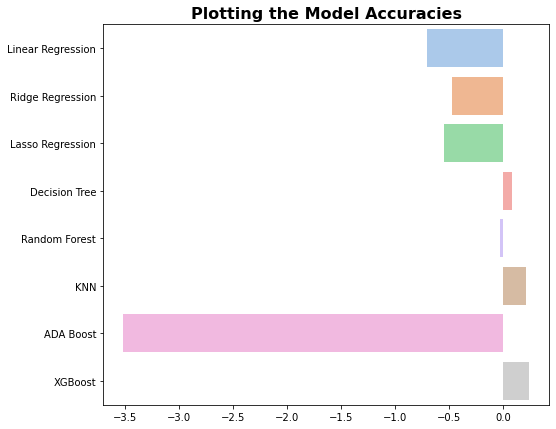

In [93]:
plt.figure(figsize= (8,7))
ac = [rlinear, rridge, rlasso, rdecisiontree, rrandomforest, rknn, rada, rxgb]
name = ['Linear Regression','Ridge Regression','Lasso Regression','Decision Tree','Random Forest','KNN','ADA Boost','XGBoost']
sns.barplot(x = ac,y = name,palette='pastel')
plt.title("Plotting the Model Accuracies", fontsize=16, fontweight="bold")

**Interpretation**

To choose **R-Square** score, we need to looking for the largest value. **R-squared** value in machine learning is referred to as the coefficient of determination or the coefficient of multiple determination in case of multiple regression.

In our case, we choose to pick **XGBoost Regressor** as our Model to predict.

#### Feature Importance

In [94]:
!pip install dalex
!pip install scikit-plot
!pip install shap

     |████████████████████████████████| 1.0 MB 26.2 MB/s 
  Created wheel for dalex: filename=dalex-1.4.1-py3-none-any.whl size=1042860 sha256=df2bcc5cfa3a32d2bb5c6047eed646e1175d6fe3ec858e20caf8724358290a21
  Stored in directory: /root/.cache/pip/wheels/8c/8e/1b/95d59374d386e8e495aed6cbab4c4b6d72be73993a424c5e12
Successfully built dalex
     |████████████████████████████████| 564 kB 27.9 MB/s 


In [95]:
# load scikit-plot modules
import scikitplot as skplt

# import dalex to explain complex model
import dalex as dx

# load shap package for shap explanation
import shap
pd.set_option("display.max_columns",None)
shap.initjs()

In [96]:
# initiate explainer for gradient boost model
xgbex = dx.Explainer(xgb, X_train, y_train, label = "XGBoost Regressor Interpretation")

Preparation of a new explainer is initiated

  -> data              : 738 rows 28 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 738 values
  -> model_class       : xgboost.sklearn.XGBRegressor (default)
  -> label             : XGBoost Regressor Interpretation
  -> predict function  : <function yhat_default at 0x7f41049fbb90> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = -2.18e+02, mean = 8.78, max = 3.62e+02
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -3.62e+03, mean = 12.8, max = 4.69e+03
  -> model_info        : package xgboost

A new explainer has been created!


In [97]:
# visualize permutation feature importance for xgboost model
xgbex.model_parts().plot()

In [98]:
# create partial dependence plot of Logistic Regression model
xgbex.model_profile().plot()

Calculating ceteris paribus: 100%|██████████| 28/28 [00:02<00:00,  9.46it/s]


In [99]:
explainer = shap.Explainer(xgb)
shap_values = explainer.shap_values(X_train[:500])

In [100]:
# visualization
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

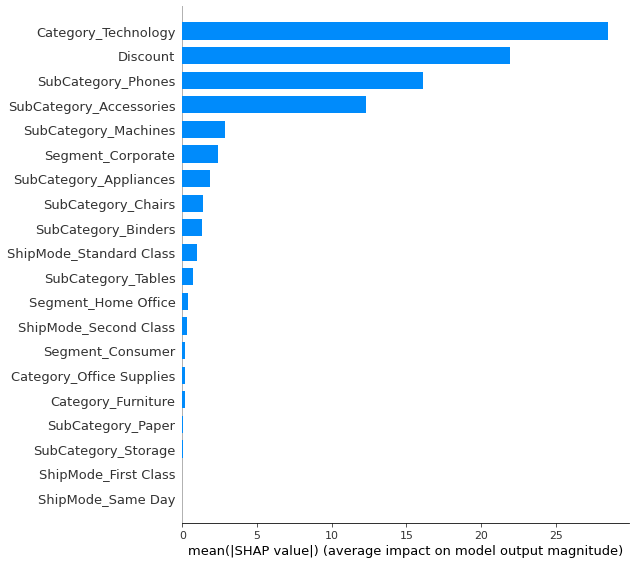

In [101]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

Based on **Dalex Explainer Summary Plot**, Category Technology have an impact due to Profit. In total Technology products had an impact on profits with an increase of $314.

On line with **Shap Explainer**, Technology product had an impact on profit in the last 3 month.

## **Time Series Forecasting**

### **Exploration**

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Total TRX'>)

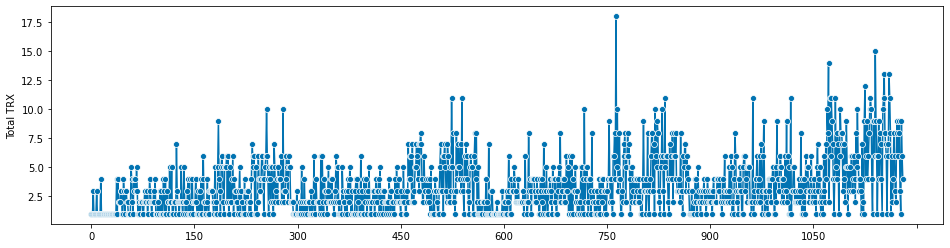

In [102]:
plot_series(daily['Total TRX'])

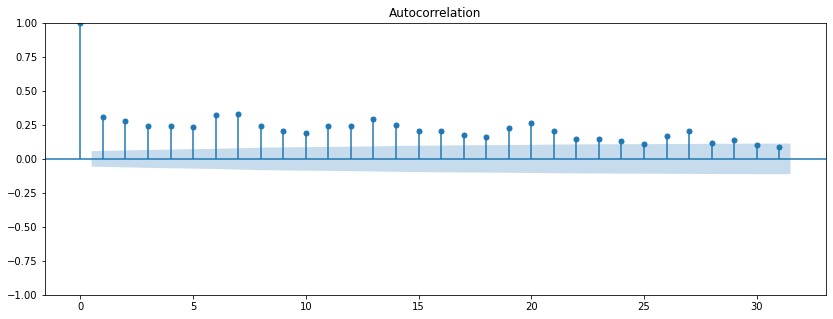

In [103]:
plot_acf(daily['Total TRX']).set_size_inches((14,5));

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.


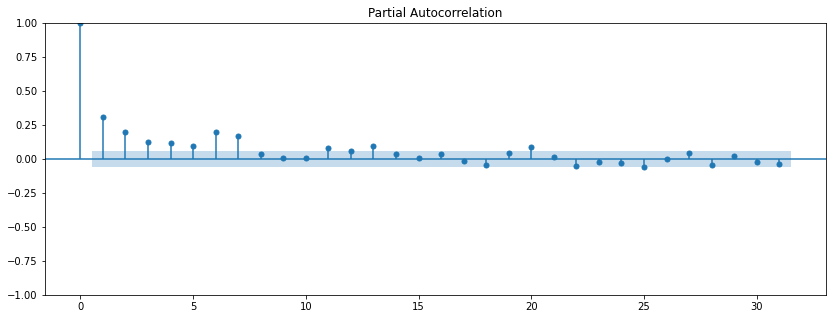

In [104]:
plot_pacf(daily['Total TRX']).set_size_inches((14,5));

### **Train Test Split**

In [105]:
# Do train-test split
y_train_trx, y_test_trx = temporal_train_test_split(daily['Total TRX'], test_size=30)

In [106]:
# Do train-test split
y_train_buyer, y_test_buyer = temporal_train_test_split(daily['Total Buyer'], test_size=30)

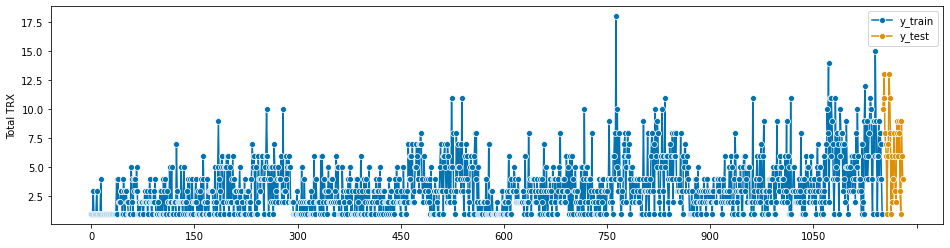

In [107]:
# check the time series after splitting
plot_series(y_train_trx, y_test_trx, labels=["y_train", "y_test"]);

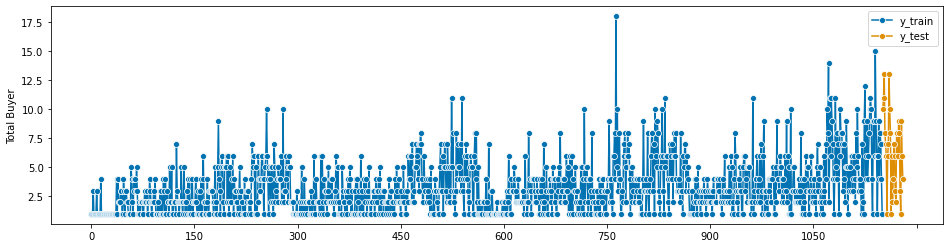

In [108]:
# check the time series after splitting
plot_series(y_train_buyer, y_test_buyer, labels=["y_train", "y_test"]);

In [111]:
#specific data points
fh_t = ForecastingHorizon(y_test_trx.index, is_relative=False)

In [112]:
#specific data points
fh_b = ForecastingHorizon(y_test_buyer.index, is_relative=False)

In [113]:
print(fh_t)
print(fh_b)

ForecastingHorizon([1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161,
            1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172,
            1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180],
           dtype='int64', is_relative=False)
ForecastingHorizon([1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161,
            1162, 1163, 1164, 1165, 1166, 1167, 1168, 1169, 1170, 1171, 1172,
            1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180],
           dtype='int64', is_relative=False)


### **Modeling**

In [114]:
# define NaiveForecaster model
naive_forecaster = NaiveForecaster(strategy="last", sp=1)

In [115]:
# fit model to train data
trx = naive_forecaster.fit(y = y_train_trx)
buyer = naive_forecaster.fit(y = y_train_buyer)

### **Predict**

In [118]:
y_pred_trx = trx.predict(fh_t)

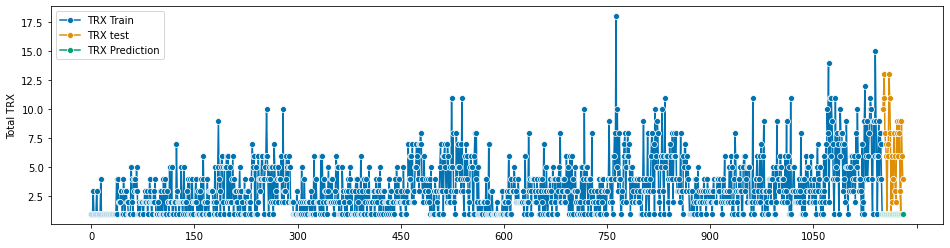

In [119]:
plot_series(y_train_trx, y_test_trx, y_pred_trx, labels=["TRX Train", "TRX test", "TRX Prediction"]);

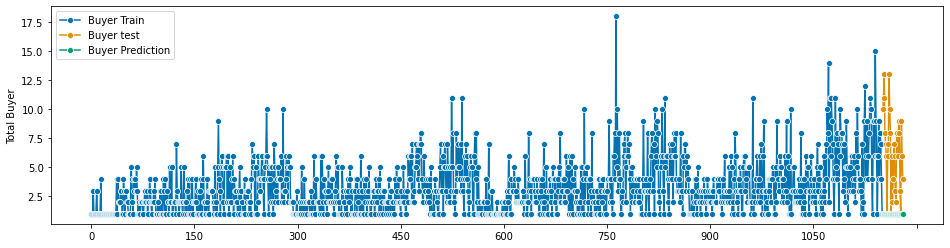

In [120]:
y_pred_buyer = buyer.predict(fh_b)
plot_series(y_train_buyer, y_test_buyer, y_pred_buyer, labels=["Buyer Train", "Buyer test", "Buyer Prediction"]);

### **Diagnostics**

In [121]:
# find residuals
residuals_trx = y_test_trx - y_pred_trx
residuals_buyer = y_test_buyer - y_pred_buyer

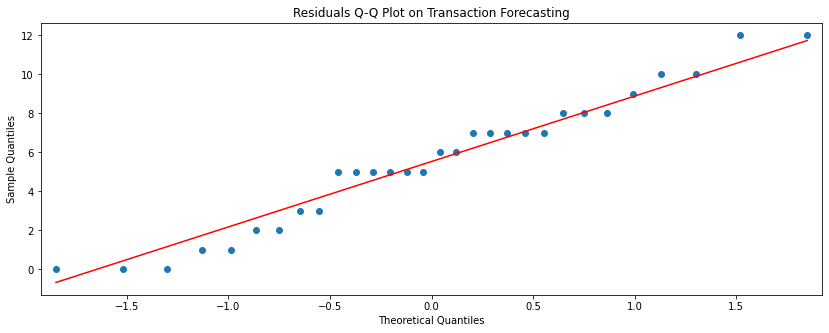

In [122]:
sm.qqplot(residuals_trx, line = 's').set_size_inches((14,5))
plt.title("Residuals Q-Q Plot on Transaction Forecasting")
plt.show()

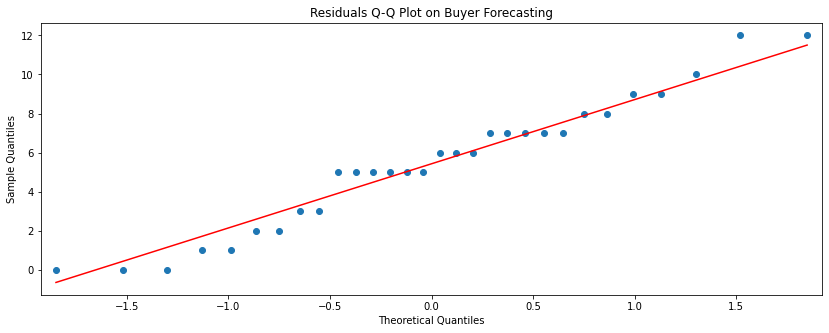

In [123]:
sm.qqplot(residuals_buyer, line = 's').set_size_inches((14,5))
plt.title("Residuals Q-Q Plot on Buyer Forecasting")
plt.show()

**Residual Random Walk Pattern**

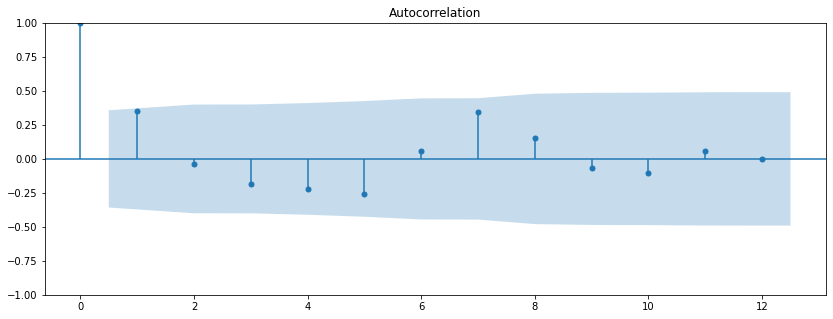

In [124]:
# ACF plot
plot_acf(
    residuals_trx, 
    lags = 12
).set_size_inches((14,5));

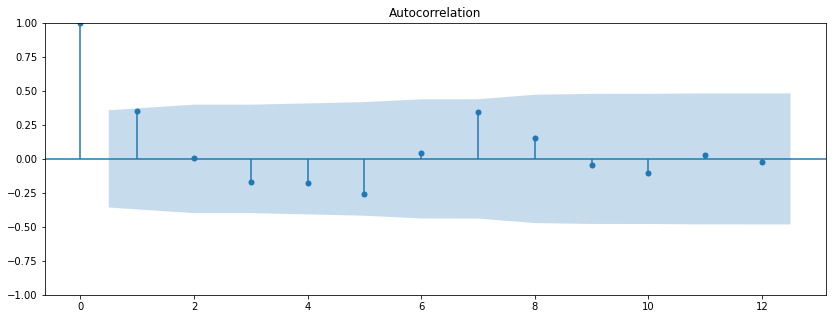

In [125]:
# ACF plot
plot_acf(
    residuals_buyer, 
    lags = 12
).set_size_inches((14,5));

**Autocorrelation Test using Ljung-Box Test**

- *Null hypothesis*: The residuals are independently distributed.
- *Alternate hypothesis*: The residuals are not independently distributed; they exhibit serial correlation.

Reject null hypothesis if **p-value less than 5%**



In [126]:
sm.stats.acorr_ljungbox(residuals_trx, lags = 10, return_df=True)

lb_stat  lb_pvalue
1    4.133521   0.042042
2    4.187328   0.123235
3    5.361280   0.147175
4    7.146517   0.128345
5    9.731376   0.083214
6    9.875073   0.130013
7   14.881513   0.037549
8   15.941282   0.043228
9   16.145582   0.063903
10  16.693173   0.081435

In [127]:
sm.stats.acorr_ljungbox(residuals_buyer, lags = 10, return_df=True)

lb_stat  lb_pvalue
1    4.045663   0.044285
2    4.046007   0.132258
3    5.068249   0.166867
4    6.228324   0.182733
5    8.842529   0.115512
6    8.920826   0.178080
7   13.861319   0.053704
8   14.907284   0.060974
9   14.990822   0.091188
10  15.494089   0.115060

**Interpretation**: Because p-value on the two of testing object greater than 5%, then we can accept the null hypothesis of the test and conclude that the residuals are independent.

In [130]:
# Transaction Error Prediction
MAE = mean_absolute_error(y_test_trx, y_pred_trx)
MSE = mean_squared_error(y_test_trx, y_pred_trx)
RMSE = np.sqrt(MSE)
MAPE = mean_absolute_percentage_error(y_test_trx, y_pred_trx)
pd.DataFrame([MAE, MSE, RMSE, MAPE], index=['MAE Transaction', 'MSE Transaction', 'RMSE Transaction','MAPE Transaction'], columns=['Metrics'])

In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.


Metrics
MAE Transaction    5.533333
MSE Transaction   41.866667
RMSE Transaction   6.470446
MAPE Transaction   1.276027

In [131]:
# Buyer Error Prediction
MAE = mean_absolute_error(y_test_buyer, y_pred_buyer)
MSE = mean_squared_error(y_test_buyer, y_pred_buyer)
RMSE = np.sqrt(MSE)
MAPE = mean_absolute_percentage_error(y_test_buyer, y_pred_buyer)
pd.DataFrame([MAE, MSE, RMSE, MAPE], index=['MAE Buyer', 'MSE Buyer', 'RMSE Buyer','MAPE Buyer'], columns=['Metrics'])

In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.


Metrics
MAE Buyer    5.433333
MSE Buyer   40.300000
RMSE Buyer   6.348228
MAPE Buyer   1.271684

### Cross Validation

In [133]:
# define CV transaction
cv = ExpandingWindowSplitter(
    initial_window = 100,
    step_length = 10,
    fh = [1, 2, 3, 4, 5,6,7,8,9,10]
)

In [134]:
# transaction
results_trx = evaluate(forecaster=trx, y=y_train_trx, cv=cv, strategy="refit", return_data=True)

# buyer
results_buyer = evaluate(forecaster=buyer, y=y_train_buyer, cv=cv, strategy="refit", return_data=True)

In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.
In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.
In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.
In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.
In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.
In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.
In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.
In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.
In the percentage error metric functions

In [136]:
# check results from transaction
results_trx

test_MeanAbsolutePercentageError  fit_time  pred_time  len_train_window  \
0                            0.540000  0.015712   0.009197               100   
1                            0.633333  0.009877   0.005041               110   
2                            0.650000  0.010170   0.005478               120   
3                            0.371429  0.010021   0.004896               130   
4                            0.593333  0.010556   0.005130               140   
..                                ...       ...        ...               ...   
100                          0.360101  0.012417   0.005102              1100   
101                          0.450087  0.013701   0.005652              1110   
102                          0.763810  0.010941   0.005262              1120   
103                          0.685275  0.013847   0.005777              1130   
104                          0.432527  0.011152   0.005287              1140   

     cutoff                                            y_train  \
0      99.0  0     1
1     1
2     1
3     3
4     1
     ....   
1     109.0  0      1
1      1
2      1
3      3
4      1
 ...   
2     119.0  0      1
1      1
2      1
3      3
4      1
 ...   
3     129.0  0      1
1      1
2      1
3      3
4      1
 ...   
4     139.0  0      1
1      1
2      1
3      3
4      1
 ...   
..      ...                                                ...   
100  1099.0  0       1
1       1
2       1
3       3
4     ...   
101  1109.0  0       1
1       1
2       1
3       3
4     ...   
102  1119.0  0       1
1       1
2       1
3       3
4     ...   
103  1129.0  0        1
1        1
2        1
3        3
4 ...   
104  1139.0  0       1
1       1
2       1
3       3
4     ...   

                                                y_test  \
0    100    3
101    1
102    3
103    1
104    1
1...   
1    110    3
111    2
112    2
113    1
114    5
1...   
2    120    2
121    2
122    2
123    1
124    7
1...   
3    130    2
131    5
132    2
133    1
134    2
1...   
4    140    3
141    4
142    1
143    4
144    1
1...   
..                                                 ...   
100  1100    1
1101    5
1102    3
1103    5
1104  ...   
101  1110     4
1111     2
1112     8
1113     5
11...   
102  1120     1
1121     7
1122     2
1123     1
11...   
103  1130     6
1131     8
1132    10
1133    11
11...   
104  1140    15
1141     9
1142     6
1143     1
11...   

                                                y_pred  
0    100    1
101    1
102    1
103    1
104    1
1...  
1    110    1
111    1
112    1
113    1
114    1
1...  
2    120    1
121    1
122    1
123    1
124    1
1...  
3    130    2
131    2
132    2
133    2
134    2
1...  
4    140    1
141    1
142    1
143    1
144    1
1...  
..                                                 ...  
100  1100    5
1101    5
1102    5
1103    5
1104  ...  
101  1110    6
1111    6
1112    6
1113    6
1114  ...  
102  1120    3
1121    3
1122    3
1123    3
1124  ...  
103  1130    4
1131    4
1132    4
1133    4
1134  ...  
104  1140    6
1141    6
1142    6
1143    6
1144  ...  

[105 rows x 8 columns]

In [137]:
# check results from buyer
results_buyer

test_MeanAbsolutePercentageError  fit_time  pred_time  len_train_window  \
0                            0.540000  0.010304   0.005104               100   
1                            0.633333  0.010389   0.005330               110   
2                            0.650000  0.010507   0.005800               120   
3                            0.371429  0.010726   0.005377               130   
4                            0.593333  0.010533   0.005310               140   
..                                ...       ...        ...               ...   
100                          0.360101  0.011036   0.005107              1100   
101                          0.450087  0.010783   0.005386              1110   
102                          0.763810  0.011446   0.005113              1120   
103                          0.685275  0.010501   0.004934              1130   
104                          0.432527  0.016503   0.005262              1140   

     cutoff                                            y_train  \
0      99.0  0     1
1     1
2     1
3     3
4     1
     ....   
1     109.0  0      1
1      1
2      1
3      3
4      1
 ...   
2     119.0  0      1
1      1
2      1
3      3
4      1
 ...   
3     129.0  0      1
1      1
2      1
3      3
4      1
 ...   
4     139.0  0      1
1      1
2      1
3      3
4      1
 ...   
..      ...                                                ...   
100  1099.0  0       1
1       1
2       1
3       3
4     ...   
101  1109.0  0       1
1       1
2       1
3       3
4     ...   
102  1119.0  0       1
1       1
2       1
3       3
4     ...   
103  1129.0  0        1
1        1
2        1
3        3
4 ...   
104  1139.0  0       1
1       1
2       1
3       3
4     ...   

                                                y_test  \
0    100    3
101    1
102    3
103    1
104    1
1...   
1    110    3
111    2
112    2
113    1
114    5
1...   
2    120    2
121    2
122    2
123    1
124    7
1...   
3    130    2
131    5
132    2
133    1
134    2
1...   
4    140    3
141    4
142    1
143    4
144    1
1...   
..                                                 ...   
100  1100    1
1101    5
1102    3
1103    5
1104  ...   
101  1110     4
1111     2
1112     8
1113     5
11...   
102  1120     1
1121     7
1122     2
1123     1
11...   
103  1130     6
1131     8
1132    10
1133    11
11...   
104  1140    15
1141     9
1142     6
1143     1
11...   

                                                y_pred  
0    100    1
101    1
102    1
103    1
104    1
1...  
1    110    1
111    1
112    1
113    1
114    1
1...  
2    120    1
121    1
122    1
123    1
124    1
1...  
3    130    2
131    2
132    2
133    2
134    2
1...  
4    140    1
141    1
142    1
143    1
144    1
1...  
..                                                 ...  
100  1100    5
1101    5
1102    5
1103    5
1104  ...  
101  1110    6
1111    6
1112    6
1113    6
1114  ...  
102  1120    3
1121    3
1122    3
1123    3
1124  ...  
103  1130    4
1131    4
1132    4
1133    4
1134  ...  
104  1140    6
1141    6
1142    6
1143    6
1144  ...  

[105 rows x 8 columns]

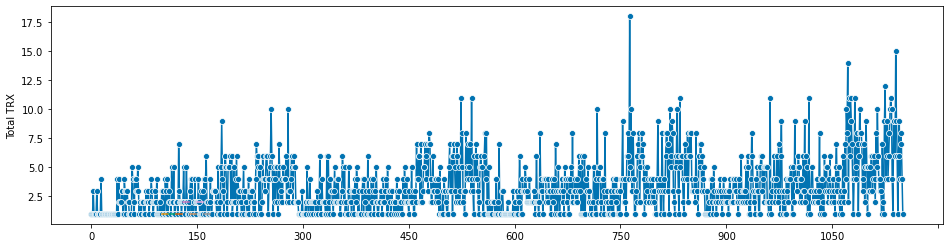

In [140]:
# plot CV transaction
plot_series(
    y_train_trx,
    results_trx["y_pred"].iloc[0],
    results_trx["y_pred"].iloc[1],
    results_trx["y_pred"].iloc[2],
    results_trx["y_pred"].iloc[3],
    results_trx["y_pred"].iloc[4],
    results_trx["y_pred"].iloc[5],
    results_trx["y_pred"].iloc[6],
    markers=["o", "", "", "", "", "", "", ""]
);

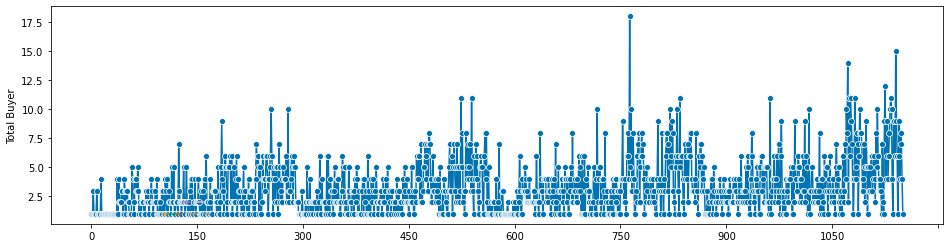

In [141]:
# plot CV transaction
plot_series(
    y_train_buyer,
    results_buyer["y_pred"].iloc[0],
    results_buyer["y_pred"].iloc[1],
    results_buyer["y_pred"].iloc[2],
    results_buyer["y_pred"].iloc[3],
    results_buyer["y_pred"].iloc[4],
    results_buyer["y_pred"].iloc[5],
    results_buyer["y_pred"].iloc[6],
    markers=["o", "", "", "", "", "", "", ""]
);

## **ARIMA Model**

**Differenced Version of Transaction and Buyer Data**

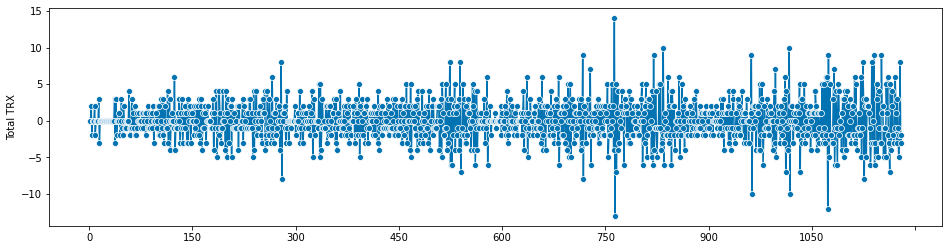

In [142]:
# plot time series transaction data
plot_series(daily['Total TRX'].diff());

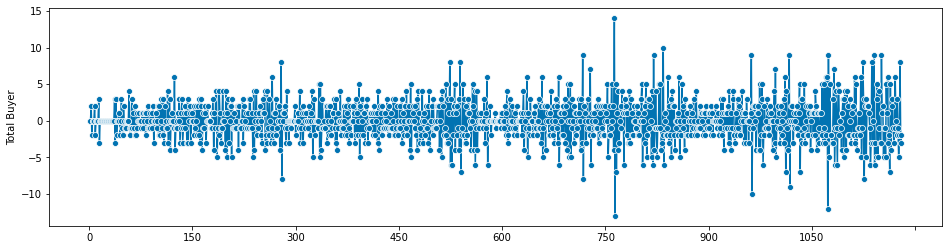

In [143]:
# plot time series buyer data
plot_series(daily['Total Buyer'].diff());

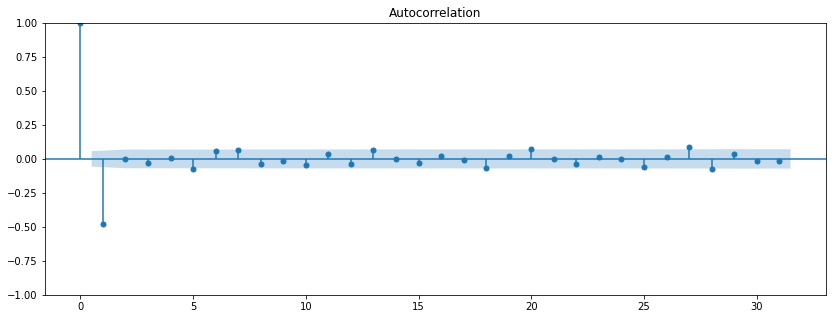

In [144]:
# plot ACF transaction
plot_acf(daily['Total TRX'].diff().dropna()).set_size_inches((14,5));

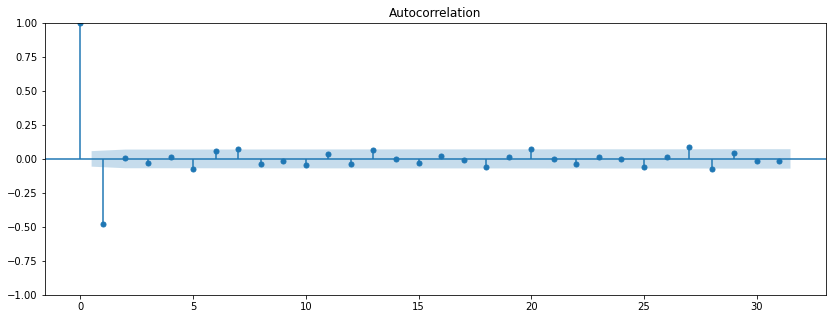

In [145]:
# plot ACF buyer
plot_acf(daily['Total Buyer'].diff().dropna()).set_size_inches((14,5));

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.


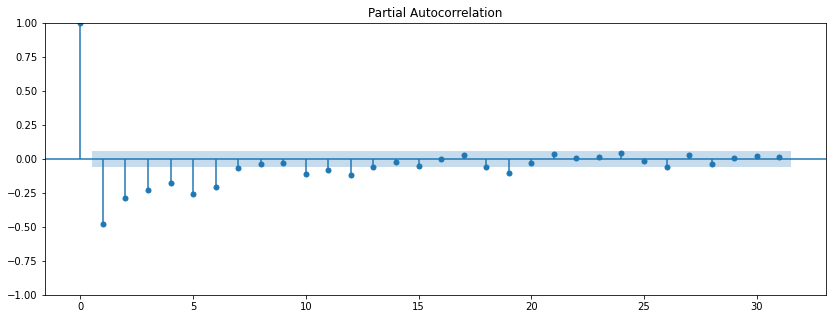

In [146]:
# plot ACF transaction
plot_pacf(daily['Total TRX'].diff().dropna()).set_size_inches((14,5));

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.


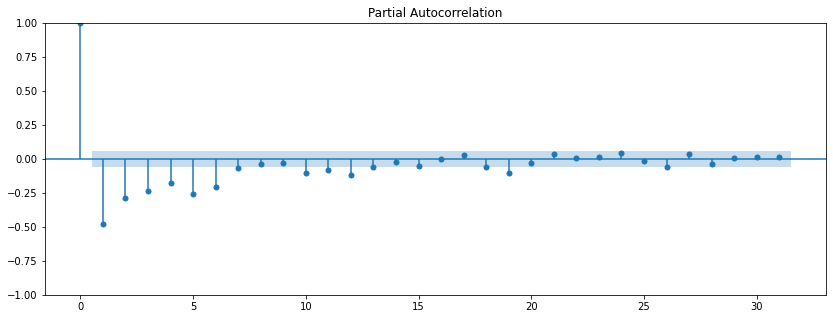

In [147]:
# plot ACF buyer
plot_pacf(daily['Total Buyer'].diff().dropna()).set_size_inches((14,5));

**Interpretation**

Both of those data interpretate as MA(1) on Differensial Transpose.

**Log-transformed Version of Transaction and Buyer Data**

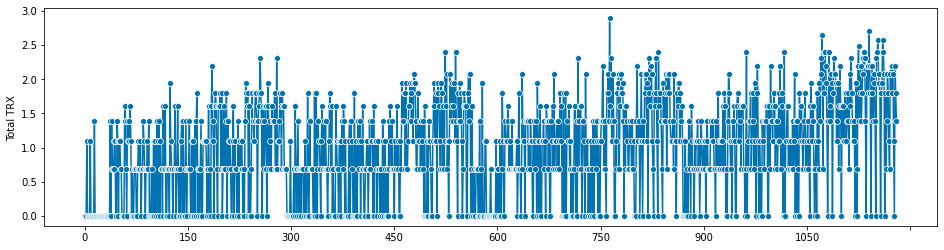

In [148]:
# plot time series transaction data
plot_series(np.log(daily['Total TRX']));

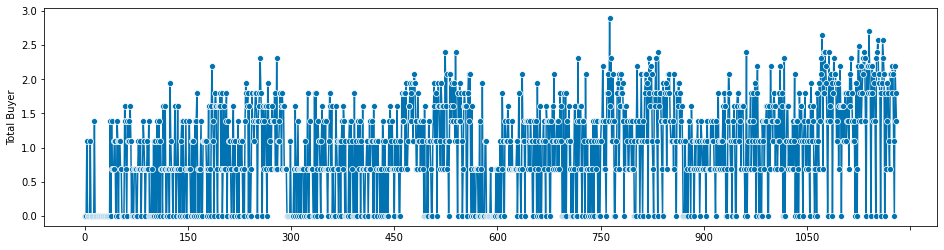

In [149]:
# plot time series transaction data
plot_series(np.log(daily['Total Buyer']));

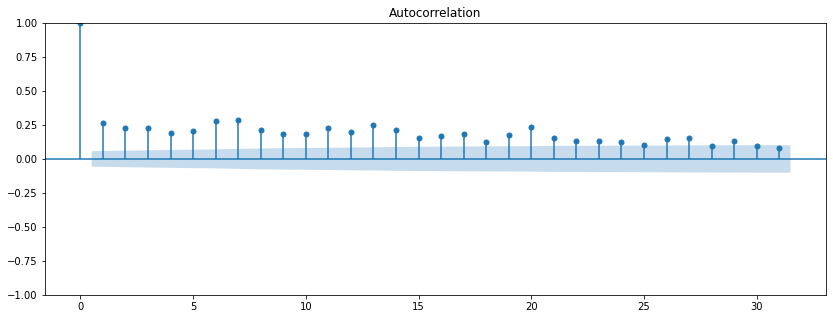

In [150]:
# plot ACF transaction
plot_acf(np.log(daily['Total TRX'])).set_size_inches((14,5));

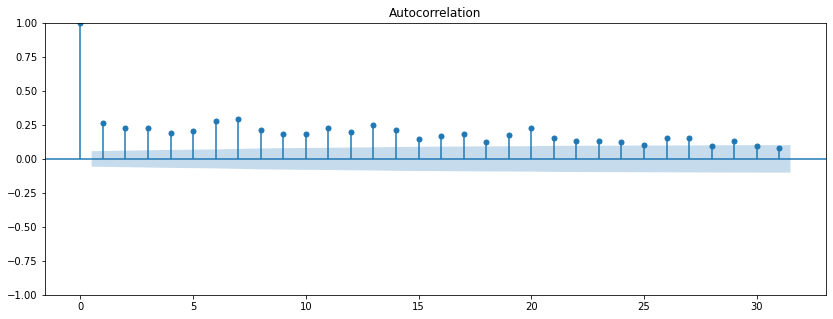

In [151]:
# plot ACF transaction
plot_acf(np.log(daily['Total Buyer'])).set_size_inches((14,5));

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.


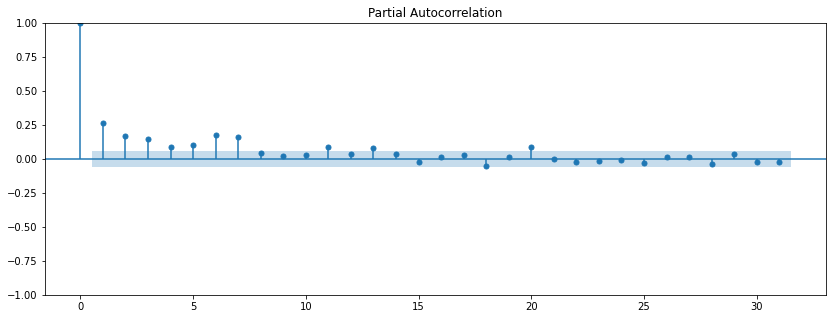

In [152]:
# plot PACF transaction
plot_pacf(np.log(daily['Total TRX'])).set_size_inches((14,5));

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.


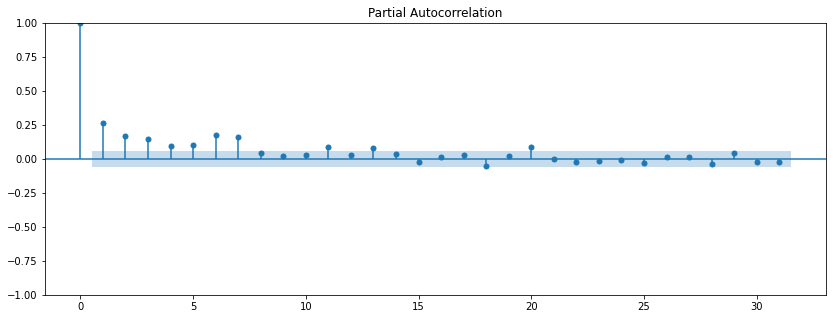

In [153]:
# plot PACF buyer
plot_pacf(np.log(daily['Total Buyer'])).set_size_inches((14,5));

**ARIMA Modeling**

In [154]:
# define arima forecaster model
arima_forecaster_trx = AutoARIMA(sp=12, suppress_warnings=True, random_state = 1000)
arima_forecaster_buyer = AutoARIMA(sp=12, suppress_warnings=True, random_state = 1000)

In [156]:
# fit forecaster to train data
trx_arima = arima_forecaster_trx.fit(y_train_trx)
buyer_arima = arima_forecaster_buyer.fit(y_train_buyer)

In [157]:
# do prediction based on forecast horizon we already defined
arima_y_pred_trx = trx_arima.predict(fh=fh_t)
arima_y_pred_buyer = buyer_arima.predict(fh=fh_b)

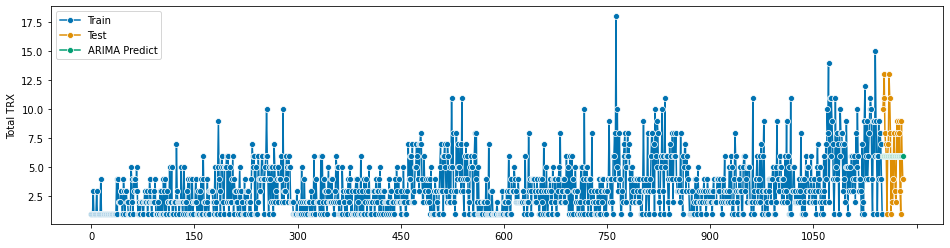

In [158]:
# plot the forecast transaction
plot_series(y_train_trx, y_test_trx, arima_y_pred_trx, labels=["Train", "Test", "ARIMA Predict"]);

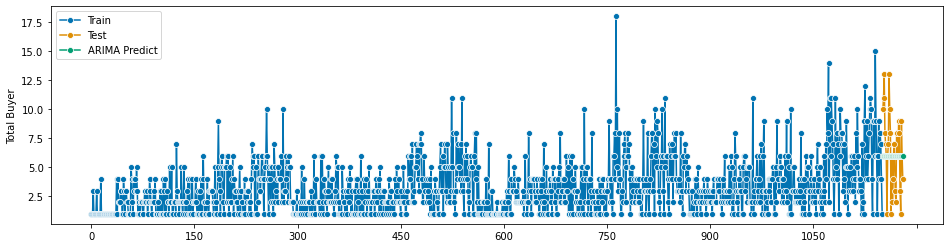

In [163]:
# plot the forecast transaction
plot_series(y_train_buyer, y_test_buyer, arima_y_pred_buyer, labels=["Train", "Test", "ARIMA Predict"]);

In [159]:
arima_forecaster_trx.get_fitted_params()

{'aic': 4936.864205528394,
 'aicc': 4936.8746676033725,
 'bic': 4946.959239971109,
 'hqic': 4940.674907078856,
 'ma.L1': -0.8980526698319904,
 'order': (0, 1, 1),
 'seasonal_order': (0, 0, 0, 12),
 'sigma2': 4.263693093955732}

In [160]:
arima_forecaster_buyer.get_fitted_params()

{'aic': 4929.833528219051,
 'aicc': 4929.843990294029,
 'bic': 4939.928562661766,
 'hqic': 4933.644229769513,
 'ma.L1': -0.8974334106401612,
 'order': (0, 1, 1),
 'seasonal_order': (0, 0, 0, 12),
 'sigma2': 4.237722810720366}

In [161]:
arima_forecaster_trx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1151
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2466.432
Date:                Wed, 11 May 2022   AIC                           4936.864
Time:                        17:00:12   BIC                           4946.959
Sample:                             0   HQIC                          4940.675
                               - 1151                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8981      0.010    -85.653      0.000      -0.919      -0.878
sigma2         4.2637      0.116     36.858      0.000       4.037       4.490
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):               581.21
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               2.47   Skew:                             0.98
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [162]:
arima_forecaster_buyer.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1151
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2462.917
Date:                Wed, 11 May 2022   AIC                           4929.834
Time:                        17:00:21   BIC                           4939.929
Sample:                             0   HQIC                          4933.644
                               - 1151                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8974      0.010    -85.575      0.000      -0.918      -0.877
sigma2         4.2377      0.115     36.822      0.000       4.012       4.463
===================================================================================
Ljung-Box (L1) (Q):                   0.41   Jarque-Bera (JB):               579.65
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               2.45   Skew:                             0.98
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Model Diagnostics**

In [164]:
# find residuals
residuals_trx = y_test_trx - arima_y_pred_trx
residuals_buyer = y_test_buyer - arima_y_pred_buyer

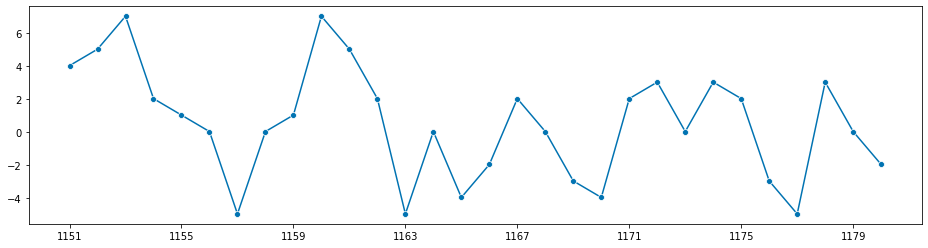

In [165]:
plot_series(residuals_trx);

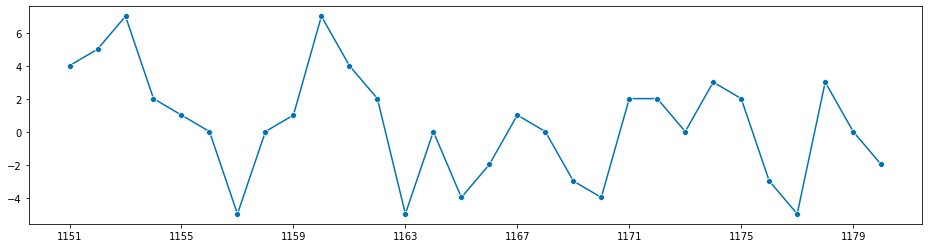

In [166]:
plot_series(residuals_buyer);

**Normality of Residuals**

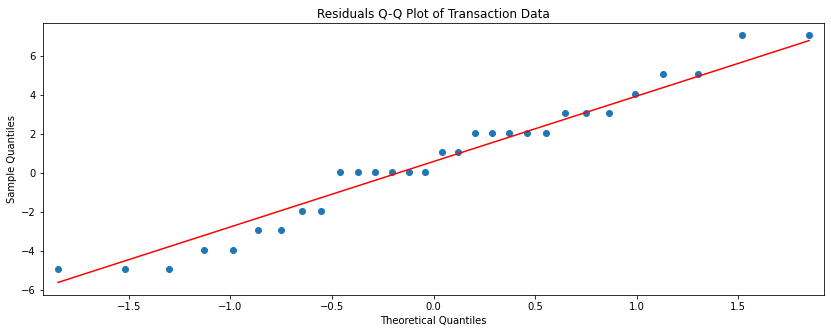

In [167]:
sm.qqplot(residuals_trx, line = 's').set_size_inches((14,5))
plt.title("Residuals Q-Q Plot of Transaction Data")
plt.show()

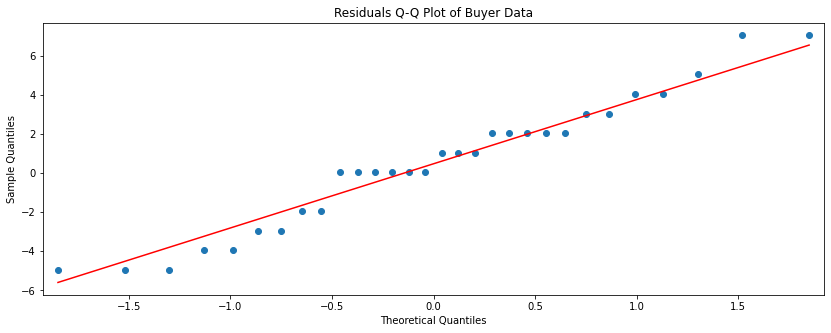

In [168]:
sm.qqplot(residuals_buyer, line = 's').set_size_inches((14,5))
plt.title("Residuals Q-Q Plot of Buyer Data")
plt.show()

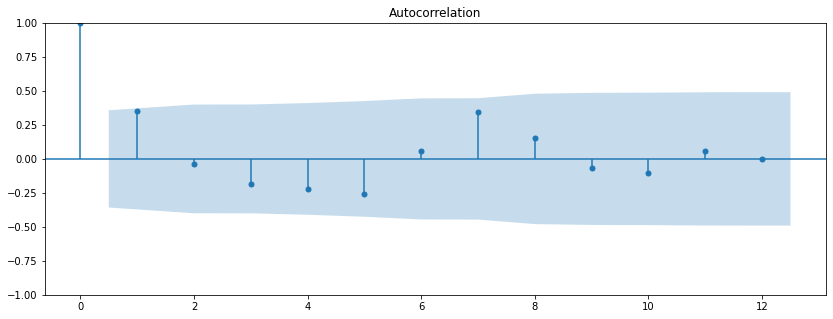

In [169]:
# ACF plot
plot_acf(
    residuals_trx, 
    lags = 12
).set_size_inches((14,5));

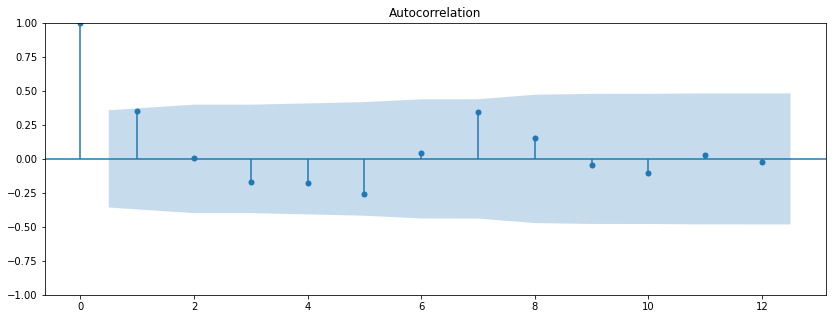

In [170]:
# ACF plot
plot_acf(
    residuals_buyer, 
    lags = 12
).set_size_inches((14,5));

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.


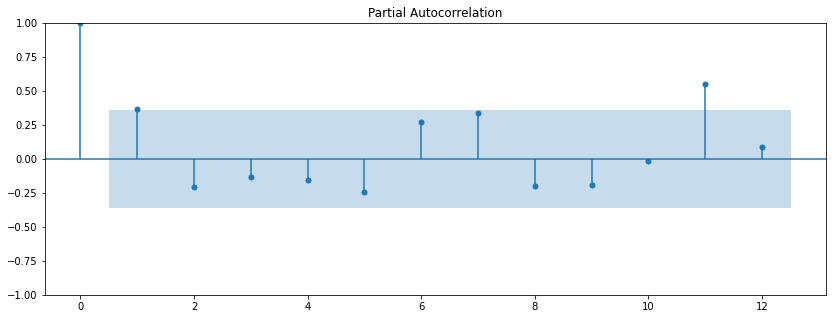

In [171]:
# PACF plot
plot_pacf(
    residuals_trx, 
    lags = 12
).set_size_inches((14,5));

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.


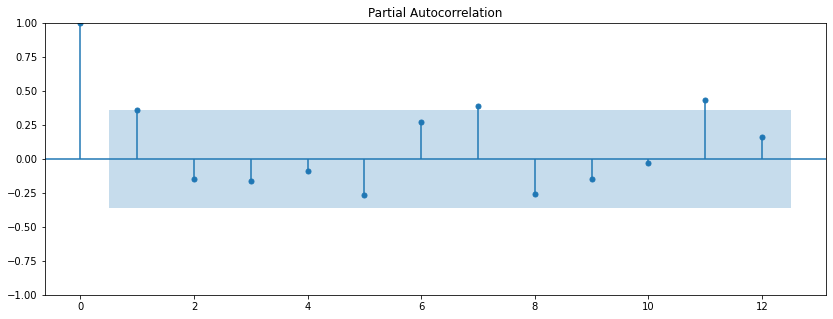

In [172]:
# PACF plot
plot_pacf(
    residuals_buyer, 
    lags = 12
).set_size_inches((14,5));

**Model Evaluation**

In [173]:
sm.stats.acorr_ljungbox(residuals_trx, lags = 10, return_df=True)

lb_stat  lb_pvalue
1    4.133521   0.042042
2    4.187328   0.123235
3    5.361280   0.147175
4    7.146517   0.128345
5    9.731376   0.083214
6    9.875073   0.130013
7   14.881513   0.037549
8   15.941282   0.043228
9   16.145582   0.063903
10  16.693173   0.081435

In [174]:
sm.stats.acorr_ljungbox(residuals_buyer, lags = 10, return_df=True)

lb_stat  lb_pvalue
1    4.045663   0.044285
2    4.046007   0.132258
3    5.068249   0.166867
4    6.228324   0.182733
5    8.842529   0.115512
6    8.920826   0.178080
7   13.861319   0.053704
8   14.907284   0.060974
9   14.990822   0.091188
10  15.494089   0.115060

In [177]:
# Transaction Error Prediction
MAE = mean_absolute_error(y_test_trx, arima_y_pred_trx)
MSE = mean_squared_error(y_test_trx, arima_y_pred_trx)
RMSE = np.sqrt(MSE)
MAPE = mean_absolute_percentage_error(y_test_trx, arima_y_pred_trx) * 100
pd.DataFrame([MAE, MSE, RMSE, MAPE], index=['MAE Transaction', 'MSE Transaction', 'RMSE Transaction','MAPE Transaction'], columns=['Metrics'])

In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.


Metrics
MAE Transaction    2.748103
MSE Transaction   11.574083
RMSE Transaction   3.402070
MAPE Transaction  48.630878

In [178]:
# Buyer Error Prediction
MAE = mean_absolute_error(y_test_trx, arima_y_pred_buyer)
MSE = mean_squared_error(y_test_trx, arima_y_pred_buyer)
RMSE = np.sqrt(MSE)
MAPE = mean_absolute_percentage_error(y_test_trx, arima_y_pred_buyer) * 100
pd.DataFrame([MAE, MSE, RMSE, MAPE], index=['MAE Transaction', 'MSE Transaction', 'RMSE Transaction','MAPE Transaction'], columns=['Metrics'])

In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.


Metrics
MAE Transaction    2.749614
MSE Transaction   11.578406
RMSE Transaction   3.402706
MAPE Transaction  48.659518

In [179]:
# define CV transaction
cv = ExpandingWindowSplitter(
    initial_window = 100,
    step_length = 10,
    fh = [1, 2, 3, 4, 5,6,7,8,9,10]
)

In [180]:
# transaction
results_trx = evaluate(forecaster=trx_arima, y=y_train_trx, cv=cv, strategy="refit", return_data=True)

# buyer
results_buyer = evaluate(forecaster=buyer_arima, y=y_train_buyer, cv=cv, strategy="refit", return_data=True)

In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.
In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.
In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.
In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.
In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.
In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.
In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.
In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.
In the percentage error metric functions

In [181]:
results_trx

test_MeanAbsolutePercentageError   fit_time  pred_time  len_train_window  \
0                            0.586364   7.101311   0.006943               100   
1                            0.425487   7.960719   0.007411               110   
2                            0.351236   4.630314   0.006655               120   
3                            0.452683  13.523942   0.006700               130   
4                            0.526964  18.724692   0.007036               140   
..                                ...        ...        ...               ...   
100                          0.410432  11.683961   0.007050              1100   
101                          0.379310  12.513933   0.006639              1110   
102                          0.648165  13.023701   0.011009              1120   
103                          0.507586  16.934086   0.007067              1130   
104                          0.428671  15.818614   0.007377              1140   

     cutoff                                            y_train  \
0      99.0  0     1
1     1
2     1
3     3
4     1
     ....   
1     109.0  0      1
1      1
2      1
3      3
4      1
 ...   
2     119.0  0      1
1      1
2      1
3      3
4      1
 ...   
3     129.0  0      1
1      1
2      1
3      3
4      1
 ...   
4     139.0  0      1
1      1
2      1
3      3
4      1
 ...   
..      ...                                                ...   
100  1099.0  0       1
1       1
2       1
3       3
4     ...   
101  1109.0  0       1
1       1
2       1
3       3
4     ...   
102  1119.0  0       1
1       1
2       1
3       3
4     ...   
103  1129.0  0        1
1        1
2        1
3        3
4 ...   
104  1139.0  0       1
1       1
2       1
3       3
4     ...   

                                                y_test  \
0    100    3
101    1
102    3
103    1
104    1
1...   
1    110    3
111    2
112    2
113    1
114    5
1...   
2    120    2
121    2
122    2
123    1
124    7
1...   
3    130    2
131    5
132    2
133    1
134    2
1...   
4    140    3
141    4
142    1
143    4
144    1
1...   
..                                                 ...   
100  1100    1
1101    5
1102    3
1103    5
1104  ...   
101  1110     4
1111     2
1112     8
1113     5
11...   
102  1120     1
1121     7
1122     2
1123     1
11...   
103  1130     6
1131     8
1132    10
1133    11
11...   
104  1140    15
1141     9
1142     6
1143     1
11...   

                                                y_pred  
0    100    1.681473
101    1.681473
102    1.68147...  
1    110    2.070776
111    2.070776
112    2.07077...  
2    120    2.233217
121    2.233217
122    2.23321...  
3    130    2.294469
131    2.294469
132    2.29446...  
4    140    2.238804
141    2.238804
142    2.23880...  
..                                                 ...  
100  1100    5.833474
1101    5.833474
1102    5.83...  
101  1110    4.890898
1111    4.890898
1112    4.89...  
102  1120    4.767919
1121    4.767919
1122    4.76...  
103  1130    5.465909
1131    5.465909
1132    5.46...  
104  1140    6.633534
1141    6.633534
1142    6.63...  

[105 rows x 8 columns]

In [182]:
results_buyer

test_MeanAbsolutePercentageError   fit_time  pred_time  len_train_window  \
0                            0.586364   3.493573   0.007685               100   
1                            0.425487   4.010968   0.006922               110   
2                            0.351236   3.411532   0.007289               120   
3                            0.452683  13.365826   0.006720               130   
4                            0.526964  18.747913   0.006722               140   
..                                ...        ...        ...               ...   
100                          0.410405  13.618342   0.009780              1100   
101                          0.379207  13.261602   0.006590              1110   
102                          0.648196  13.998662   0.006840              1120   
103                          0.507270  15.897930   0.007044              1130   
104                          0.428641  15.838011   0.006938              1140   

     cutoff                                            y_train  \
0      99.0  0     1
1     1
2     1
3     3
4     1
     ....   
1     109.0  0      1
1      1
2      1
3      3
4      1
 ...   
2     119.0  0      1
1      1
2      1
3      3
4      1
 ...   
3     129.0  0      1
1      1
2      1
3      3
4      1
 ...   
4     139.0  0      1
1      1
2      1
3      3
4      1
 ...   
..      ...                                                ...   
100  1099.0  0       1
1       1
2       1
3       3
4     ...   
101  1109.0  0       1
1       1
2       1
3       3
4     ...   
102  1119.0  0       1
1       1
2       1
3       3
4     ...   
103  1129.0  0        1
1        1
2        1
3        3
4 ...   
104  1139.0  0       1
1       1
2       1
3       3
4     ...   

                                                y_test  \
0    100    3
101    1
102    3
103    1
104    1
1...   
1    110    3
111    2
112    2
113    1
114    5
1...   
2    120    2
121    2
122    2
123    1
124    7
1...   
3    130    2
131    5
132    2
133    1
134    2
1...   
4    140    3
141    4
142    1
143    4
144    1
1...   
..                                                 ...   
100  1100    1
1101    5
1102    3
1103    5
1104  ...   
101  1110     4
1111     2
1112     8
1113     5
11...   
102  1120     1
1121     7
1122     2
1123     1
11...   
103  1130     6
1131     8
1132    10
1133    11
11...   
104  1140    15
1141     9
1142     6
1143     1
11...   

                                                y_pred  
0    100    1.681473
101    1.681473
102    1.68147...  
1    110    2.070776
111    2.070776
112    2.07077...  
2    120    2.233217
121    2.233217
122    2.23321...  
3    130    2.294469
131    2.294469
132    2.29446...  
4    140    2.238804
141    2.238804
142    2.23880...  
..                                                 ...  
100  1100    5.832984
1101    5.832984
1102    5.83...  
101  1110    4.888181
1111    4.888181
1112    4.88...  
102  1120    4.765494
1121    4.765494
1122    4.76...  
103  1130    5.468767
1131    5.468767
1132    5.46...  
104  1140    6.63781
1141    6.63781
1142    6.6378...  

[105 rows x 8 columns]

## Exponential Smoothing

In [185]:
# Transaction Model
# define ets forecaster model
ets_forecaster_trx = ExponentialSmoothing(trend='add', seasonal='multiplicative', sp=12)
# fit forecaster to train data
ets_forecaster_trx = ets_forecaster_trx.fit(y_train_trx)
# do prediction based on forecast horizon we already defined
y_pred_ets_trx = ets_forecaster_trx.predict(fh=fh_t)

In [186]:
# Buyer Model
# define ets forecaster model
ets_forecaster_buyer = ExponentialSmoothing(trend='add', seasonal='multiplicative', sp=12)
# fit forecaster to train data
ets_forecaster_buyer = ets_forecaster_buyer.fit(y_train_buyer)
# do prediction based on forecast horizon we already defined
y_pred_ets_buyer = ets_forecaster_buyer.predict(fh=fh_b)

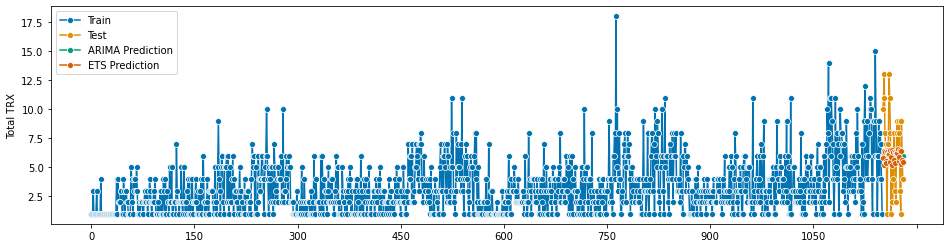

In [187]:
# plot the forecast trx
plot_series(y_train_trx, y_test_trx, arima_y_pred_trx, y_pred_ets_trx, labels=["Train", "Test", "ARIMA Prediction", "ETS Prediction"]);

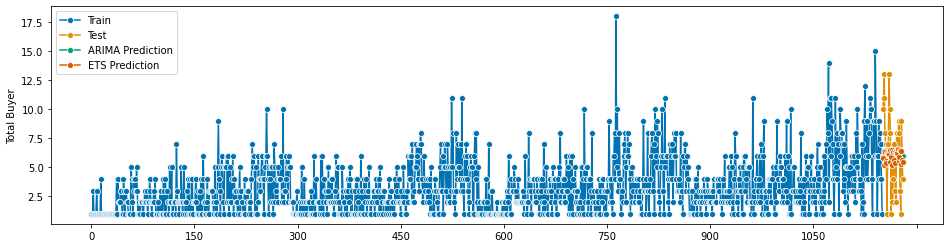

In [188]:
# plot the forecast buyer
plot_series(y_train_buyer, y_test_buyer, arima_y_pred_buyer, y_pred_ets_buyer, labels=["Train", "Test", "ARIMA Prediction", "ETS Prediction"]);

**Check Model Specs**

In [189]:
ets_forecaster_trx.get_fitted_params()

{'aic': 1680.452003919462,
 'aicc': 1681.0562442021476,
 'bic': 1761.226186459012,
 'initial_level': 0.7265671709976151,
 'initial_seasons': array([1.89149025, 1.52194002, 1.84445473, 1.63855063, 1.56924969,
        1.83977821, 1.80012064, 1.7907005 , 1.80312067, 1.90683175,
        1.60465902, 1.71237536]),
 'initial_slope': None}

In [190]:
ets_forecaster_buyer.get_fitted_params()

{'aic': 1673.8490963849674,
 'aicc': 1674.453336667653,
 'bic': 1754.6232789245175,
 'initial_level': 0.7478940740404463,
 'initial_seasons': array([1.84779337, 1.48991648, 1.80500622, 1.59786991, 1.53736287,
        1.79097409, 1.76324369, 1.75262063, 1.76265064, 1.85588433,
        1.56959586, 1.67087986]),
 'initial_slope': None}

**Model Diagnostics**

In [191]:
# find residuals
residuals_ets_trx = y_test_trx - y_pred_ets_trx
residuals_ets_buyer = y_test_buyer - y_pred_ets_buyer

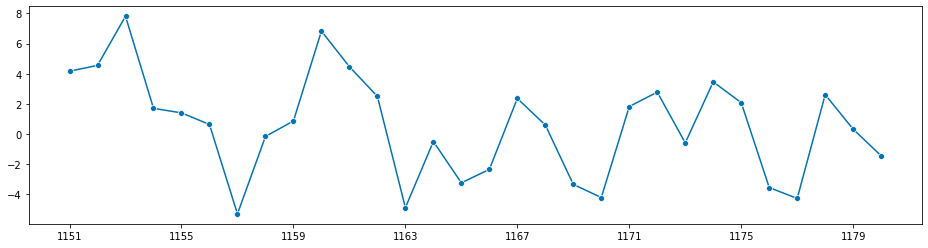

In [192]:
plot_series(residuals_ets_trx);

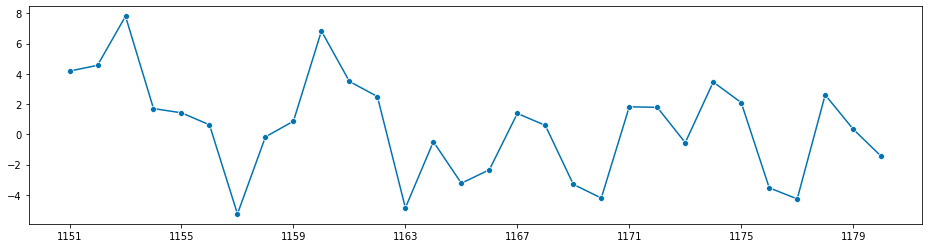

In [193]:
plot_series(residuals_ets_buyer);

**Normality of Residuals**

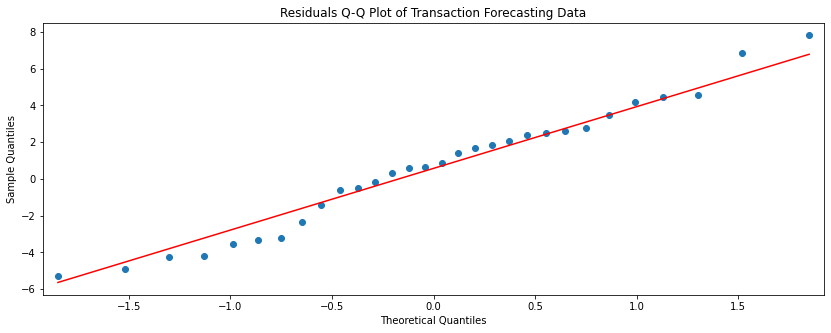

In [194]:
sm.qqplot(residuals_ets_trx, line = 's').set_size_inches((14,5))
plt.title("Residuals Q-Q Plot of Transaction Forecasting Data")
plt.show()

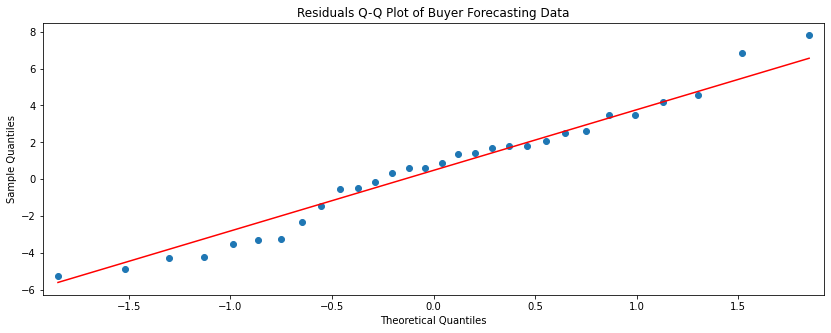

In [195]:
sm.qqplot(residuals_ets_buyer, line = 's').set_size_inches((14,5))
plt.title("Residuals Q-Q Plot of Buyer Forecasting Data")
plt.show()

**Randon Walk Pattern of Residuals**

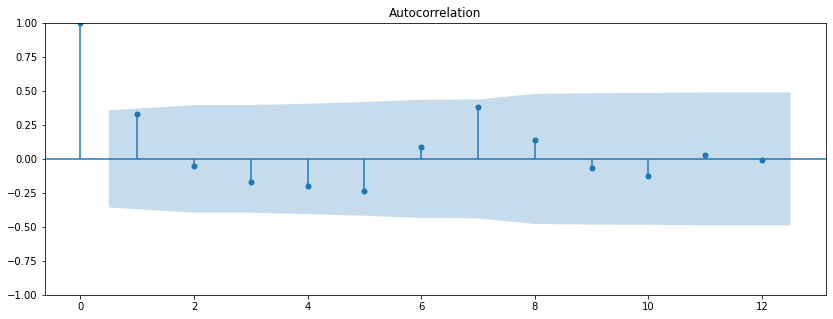

In [196]:
# ACF plot
plot_acf(
    residuals_ets_trx, 
    lags = 12
).set_size_inches((14,5));

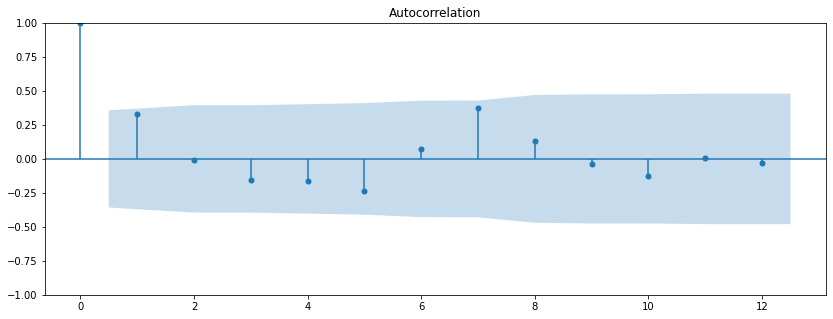

In [197]:
# ACF plot
plot_acf(
    residuals_ets_buyer, 
    lags = 12
).set_size_inches((14,5));

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.


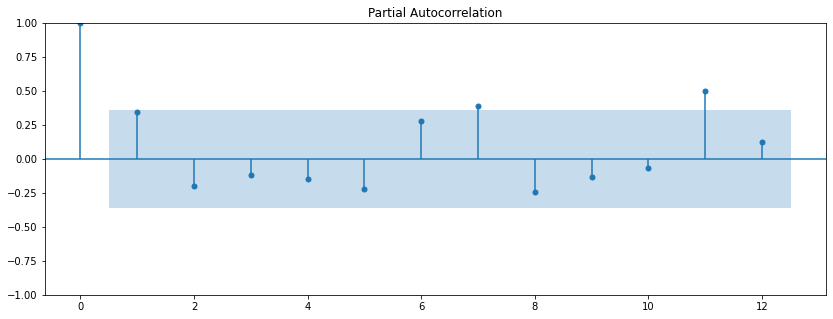

In [198]:
# ACF plot
plot_pacf(
    residuals_ets_trx, 
    lags = 12
).set_size_inches((14,5));

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.


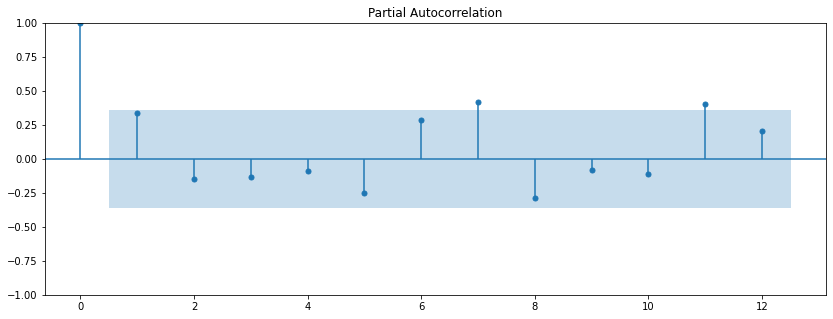

In [199]:
# ACF plot
plot_pacf(
    residuals_ets_buyer, 
    lags = 12
).set_size_inches((14,5));

In [200]:
# Transaction Error Prediction
MAE = mean_absolute_error(y_test_trx, y_pred_ets_trx)
MSE = mean_squared_error(y_test_trx, y_pred_ets_trx)
RMSE = np.sqrt(MSE)
MAPE = mean_absolute_percentage_error(y_test_trx, y_pred_ets_trx) * 100
pd.DataFrame([MAE, MSE, RMSE, MAPE], index=['MAE Transaction', 'MSE Transaction', 'RMSE Transaction','MAPE Transaction'], columns=['Metrics'])

In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.


Metrics
MAE Transaction    2.824835
MSE Transaction   11.600860
RMSE Transaction   3.406003
MAPE Transaction  50.043069

In [201]:
# Buyer Error Prediction
MAE = mean_absolute_error(y_test_trx, y_pred_ets_buyer)
MSE = mean_squared_error(y_test_trx, y_pred_ets_buyer)
RMSE = np.sqrt(MSE)
MAPE = mean_absolute_percentage_error(y_test_trx, y_pred_ets_buyer) * 100
pd.DataFrame([MAE, MSE, RMSE, MAPE], index=['MAE Transaction', 'MSE Transaction', 'RMSE Transaction','MAPE Transaction'], columns=['Metrics'])

In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.


Metrics
MAE Transaction    2.824585
MSE Transaction   11.599424
RMSE Transaction   3.405793
MAPE Transaction  50.049103

## AutoETS

In [202]:
# Modeling
# define auto ets forecaster model
forecaster_auto_ets_trx = AutoETS(auto=True, sp=12)
# fit forecaster to train data
forecaster_auto_ets_trx= forecaster_auto_ets_trx.fit(y_train_trx)
# do prediction based on forecast horizon we already defined
y_pred_auto_ets_trx = forecaster_auto_ets_trx.predict(fh=fh_t)

In [204]:
# Modeling
# define auto ets forecaster model
forecaster_auto_ets_buyer = AutoETS(auto=True, sp=12)
# fit forecaster to train data
forecaster_auto_ets_buyer= forecaster_auto_ets_buyer.fit(y_train_buyer)
# do prediction based on forecast horizon we already defined
y_pred_auto_ets_buyer = forecaster_auto_ets_buyer.predict(fh=fh_b)

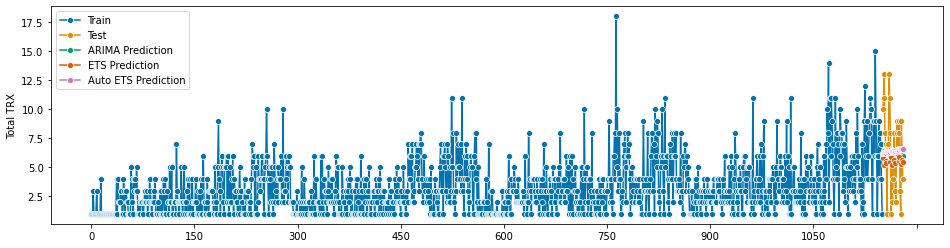

In [205]:
# plot the forecast trx
plot_series(y_train_trx, y_test_trx, arima_y_pred_trx, y_pred_ets_trx, y_pred_auto_ets_trx, labels=["Train", "Test", "ARIMA Prediction", "ETS Prediction","Auto ETS Prediction"]);

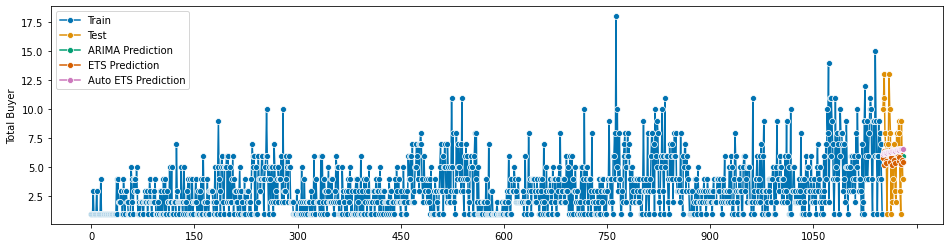

In [206]:
# plot the forecast buyer
plot_series(y_train_buyer, y_test_buyer, arima_y_pred_buyer, y_pred_ets_buyer, y_pred_auto_ets_buyer, labels=["Train", "Test", "ARIMA Prediction", "ETS Prediction","Auto ETS Prediction"]);

**Residual**

In [207]:
# find residuals
residuals_auto_ets_trx = y_test_trx - y_pred_auto_ets_trx
residuals_auto_ets_buyer = y_test_buyer - y_pred_auto_ets_buyer

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

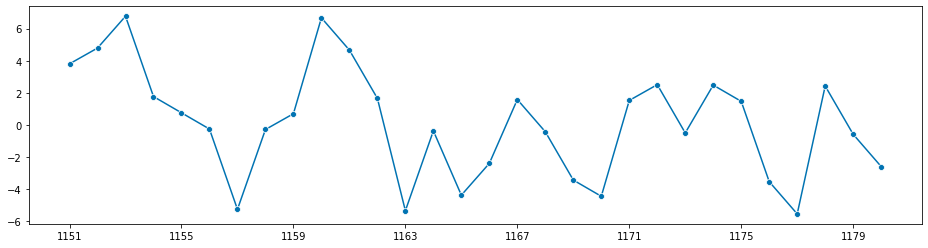

In [208]:
# plot of residual auto ETS trx
plot_series(residuals_auto_ets_trx)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

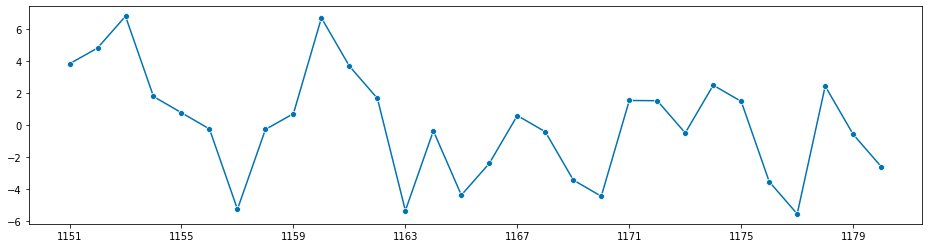

In [209]:
# plot of residual auto ETS buyer
plot_series(residuals_auto_ets_buyer)

**Normality of Residuals**

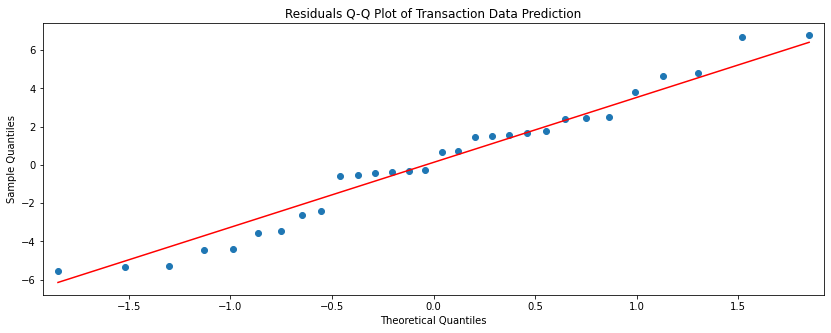

In [210]:
sm.qqplot(residuals_auto_ets_trx, line = 's').set_size_inches((14,5))
plt.title("Residuals Q-Q Plot of Transaction Data Prediction")
plt.show()

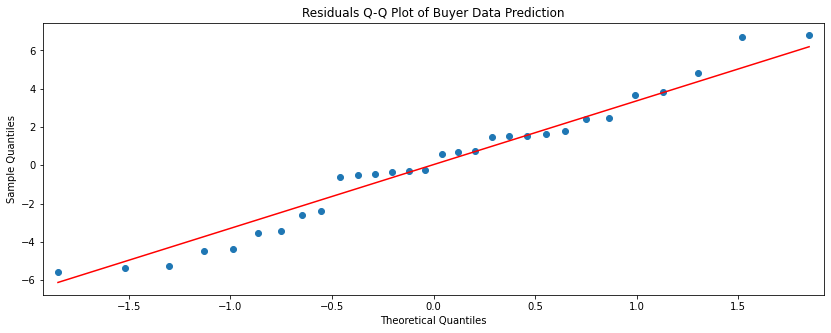

In [211]:
sm.qqplot(residuals_auto_ets_buyer, line = 's').set_size_inches((14,5))
plt.title("Residuals Q-Q Plot of Buyer Data Prediction")
plt.show()

**Random Walk Pattern of Residuals**

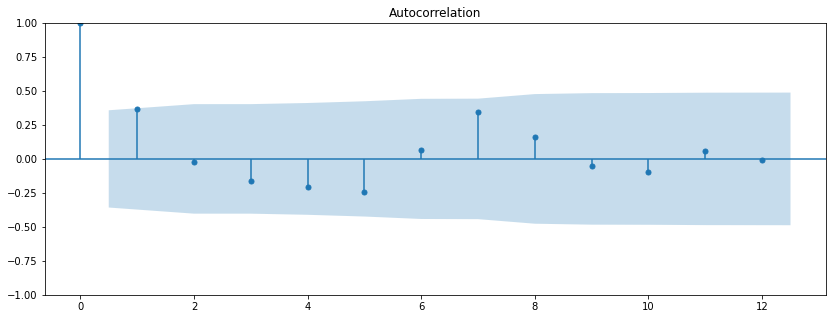

In [212]:
# trx ACF plot
plot_acf(
    residuals_auto_ets_trx, 
    lags = 12
).set_size_inches((14,5));

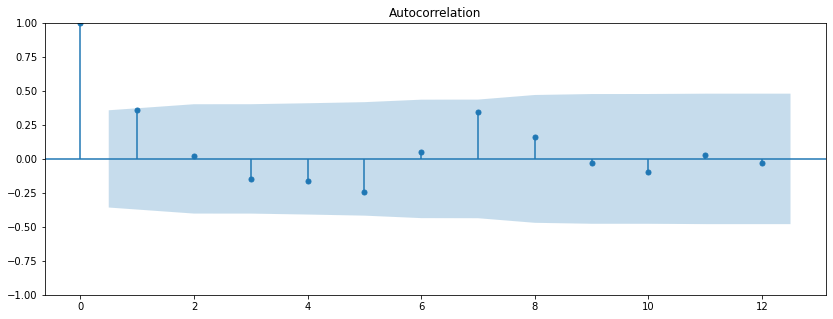

In [213]:
# buyer ACF plot
plot_acf(
    residuals_auto_ets_buyer, 
    lags = 12
).set_size_inches((14,5));

In [214]:
# Buyer Error Prediction
MAE = mean_absolute_error(y_test_trx, y_pred_auto_ets_trx)
MSE = mean_squared_error(y_test_trx, y_pred_auto_ets_trx)
RMSE = np.sqrt(MSE)
MAPE = mean_absolute_percentage_error(y_test_trx, y_pred_auto_ets_trx) * 100
pd.DataFrame([MAE, MSE, RMSE, MAPE], index=['MAE', 'MSE', 'RMSE','MAPE'], columns=['Metrics'])

In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.


Metrics
MAE    2.769890
MSE   11.561987
RMSE   3.400292
MAPE  48.483980

In [215]:
# Buyer Error Prediction
MAE = mean_absolute_error(y_test_trx, y_pred_auto_ets_buyer)
MSE = mean_squared_error(y_test_trx, y_pred_auto_ets_buyer)
RMSE = np.sqrt(MSE)
MAPE = mean_absolute_percentage_error(y_test_trx, y_pred_auto_ets_buyer) * 100
pd.DataFrame([MAE, MSE, RMSE, MAPE], index=['MAE', 'MSE', 'RMSE','MAPE'], columns=['Metrics'])

In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.


Metrics
MAE    2.770894
MSE   11.572071
RMSE   3.401775
MAPE  48.504493

## TBATS

In [216]:
# define TBATS model for trx
tbats_forecaster_trx = TBATS(sp=12)
# fit forecaster to data
tbats_forecaster_trx= tbats_forecaster_trx.fit(y_train_trx)
# do prediction based on forecast horizon we already defined
y_pred_tbats_trx = tbats_forecaster_trx.predict(fh=fh_t)

overflow encountered in exp


In [217]:
# define TBATS model for trx
tbats_forecaster_buyer = TBATS(sp=12)
# fit forecaster to data
tbats_forecaster_buyer= tbats_forecaster_buyer.fit(y_train_buyer)
# do prediction based on forecast horizon we already defined
y_pred_tbats_buyer = tbats_forecaster_buyer.predict(fh=fh_b)

overflow encountered in exp


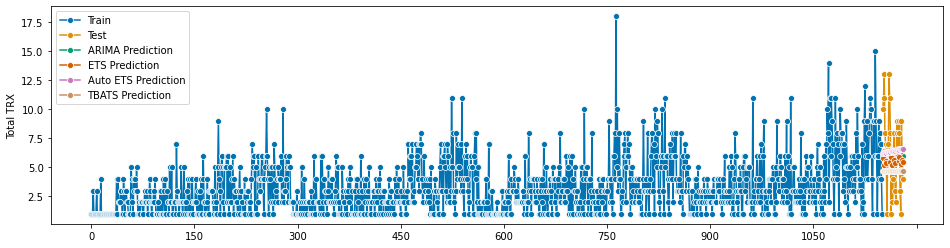

In [218]:
# plot the forecast trx
plot_series(y_train_trx, y_test_trx, arima_y_pred_trx, y_pred_ets_trx, y_pred_auto_ets_trx,y_pred_tbats_trx, labels=["Train", "Test", "ARIMA Prediction", "ETS Prediction","Auto ETS Prediction","TBATS Prediction"]);

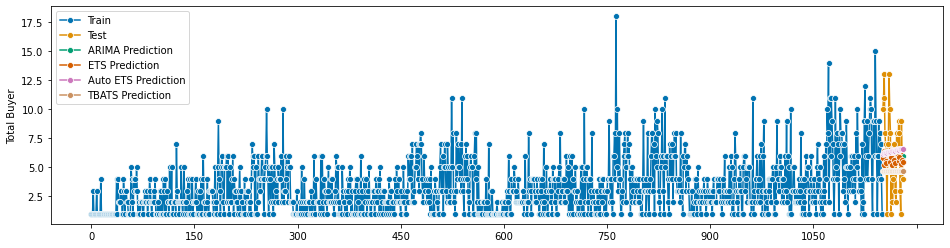

In [219]:
# plot the forecast buyer
plot_series(y_train_buyer, y_test_buyer, arima_y_pred_buyer, y_pred_ets_buyer, y_pred_auto_ets_buyer,y_pred_tbats_buyer, labels=["Train", "Test", "ARIMA Prediction", "ETS Prediction","Auto ETS Prediction","TBATS Prediction"]);

**Residual**

In [220]:
# find residuals
residuals_tbats_trx = y_test_trx - y_pred_tbats_trx
residuals_tbats_buyer = y_test_buyer - y_pred_tbats_buyer

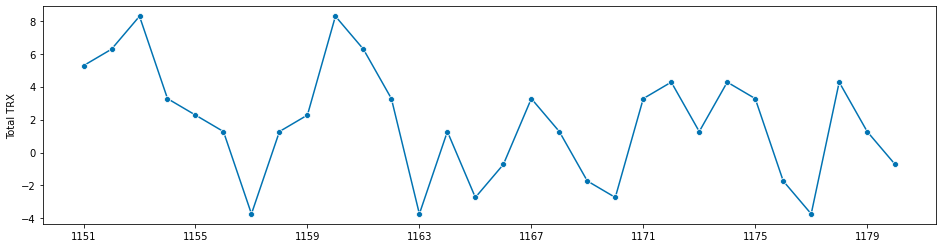

In [221]:
plot_series(residuals_tbats_trx);

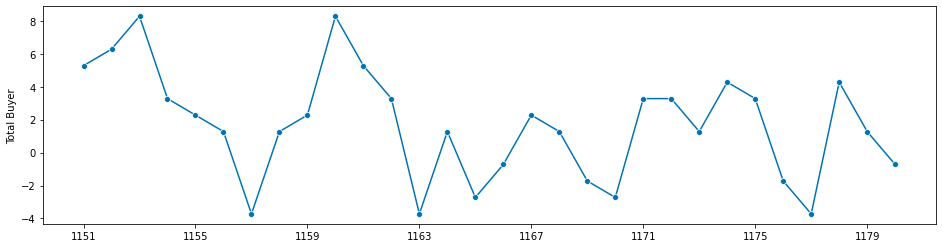

In [222]:
plot_series(residuals_tbats_buyer);

**Normality Plot of Residuals**

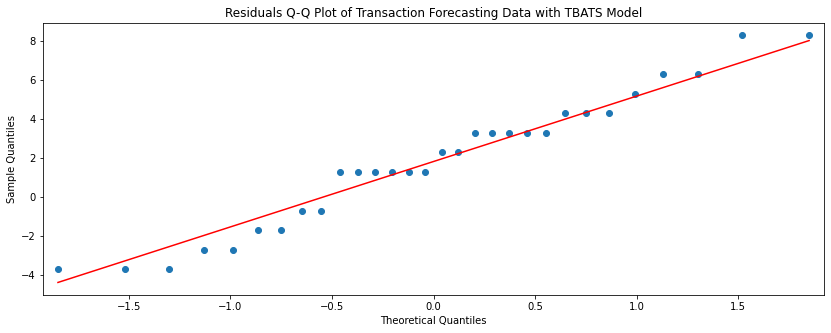

In [223]:
sm.qqplot(residuals_tbats_trx, line = 's').set_size_inches((14,5))
plt.title("Residuals Q-Q Plot of Transaction Forecasting Data with TBATS Model")
plt.show()

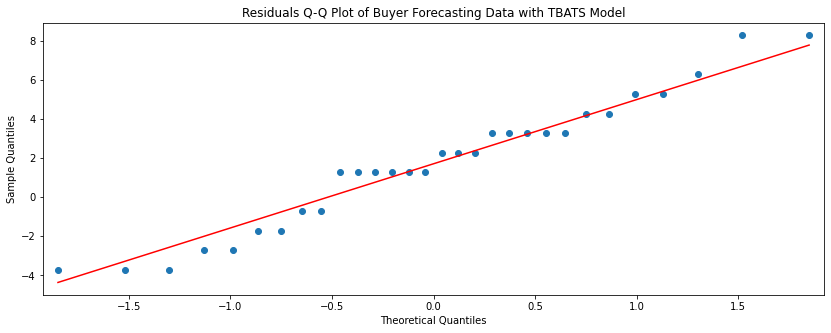

In [224]:
sm.qqplot(residuals_tbats_buyer, line = 's').set_size_inches((14,5))
plt.title("Residuals Q-Q Plot of Buyer Forecasting Data with TBATS Model")
plt.show()

**Model Evaluation**

In [225]:
# Transaction Error Prediction
MAE = mean_absolute_error(y_test_trx, y_pred_tbats_trx)
MSE = mean_squared_error(y_test_trx, y_pred_tbats_trx)
RMSE = np.sqrt(MSE)
MAPE = mean_absolute_percentage_error(y_test_trx, y_pred_tbats_trx) * 100
pd.DataFrame([MAE, MSE, RMSE, MAPE], index=['MAE', 'MSE', 'RMSE','MAPE'], columns=['Metrics'])

In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.


Metrics
MAE    3.242203
MSE   14.508744
RMSE   3.809034
MAPE  58.561385

In [226]:
# Buyer Error Prediction
MAE = mean_absolute_error(y_test_trx, y_pred_tbats_buyer)
MSE = mean_squared_error(y_test_trx, y_pred_tbats_buyer)
RMSE = np.sqrt(MSE)
MAPE = mean_absolute_percentage_error(y_test_trx, y_pred_tbats_buyer) * 100
pd.DataFrame([MAE, MSE, RMSE, MAPE], index=['MAE', 'MSE', 'RMSE','MAPE'], columns=['Metrics'])

In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.


Metrics
MAE    3.243546
MSE   14.520883
RMSE   3.810628
MAPE  58.589925

## Prophet

In [255]:
# set Date as index
daily = daily.set_index('OrderDate')
daily.index = pd.DatetimeIndex(daily.index, freq = 'infer')

**Split Transaction & Buyer Data**

In [256]:
# Do train-test split
y_train_trx, y_test_trx = temporal_train_test_split(daily['Total TRX'], test_size=36)
y_train_buyer, y_test_buyer = temporal_train_test_split(daily['Total Buyer'], test_size=36)

In [257]:
#specific data points
fh_t = ForecastingHorizon(y_test_trx.index, is_relative=False)
fh_b = ForecastingHorizon(y_test_buyer.index, is_relative=False)

**US Holiday**

In [258]:
# define US holiday
ny = pd.DataFrame({'holiday': "New Year's Day", 'ds' : pd.to_datetime(['2015-01-01','2016-01-01','2017-01-01'])})  
mlk = pd.DataFrame({'holiday': 'Birthday of Martin Luther King, Jr.', 'ds' : pd.to_datetime(['2014-01-18','2015-01-18','2016-01-18','2017-01-16'])}) 
wash = pd.DataFrame({'holiday': "Washington's Birthday", 'ds' : pd.to_datetime(['2014-02-15','2015-02-15','2016-02-15','2017-02-20'])})
mem = pd.DataFrame({'holiday': 'Memorial Day', 'ds' : pd.to_datetime(['2014-05-30','2015-05-30','2016-05-30','2017-05-29'])})
ind = pd.DataFrame({'holiday': 'Independence Day', 'ds' : pd.to_datetime(['2014-07-04','2015-07-04','2016-07-04','2017-07-04'])})
lab = pd.DataFrame({'holiday': 'Labor Day', 'ds' : pd.to_datetime(['2014-09-07','2015-09-07','2016-09-05','2017-09-04'])})
col = pd.DataFrame({'holiday': 'Columbus Day', 'ds' : pd.to_datetime(['2014-10-12','2015-10-12','2016-10-10','2017-10-09'])})
vet = pd.DataFrame({'holiday': "Veteran's Day", 'ds' : pd.to_datetime(['2014-11-11','2015-11-11','2016-11-11','2017-11-11'])})
thanks = pd.DataFrame({'holiday': 'Thanksgiving Day', 'ds' : pd.to_datetime(['2014-11-26','2015-11-26','2016-11-24','2017-11-26'])})
christ = pd.DataFrame({'holiday': 'Christmas', 'ds' : pd.to_datetime(['2014-12-25','2015-12-25','2016-12-25','2017-12-25'])})
inaug = pd.DataFrame({'holiday': 'Inauguration Day', 'ds' : pd.to_datetime(['2017-01-20'])})

us_public_holidays = pd.concat([ny, mlk, wash, mem, ind, lab, col, vet, thanks, christ, inaug])

In [259]:
# define Prophet model for trx
prophet_forecaster_trx = Prophet(
    seasonality_mode='multiplicative', 
    yearly_seasonality = True,
    weekly_seasonality = True,
    daily_seasonality = False,
    holidays = us_public_holidays
)
# fit forecaster to data
prophet_forecaster_trx=prophet_forecaster_trx.fit(y_train_trx)
# do prediction based on forecast horizon we already defined
y_pred_prophet_trx = prophet_forecaster_trx.predict(fh=fh_t)

In [260]:
# define Prophet model for buyer
prophet_forecaster_buyer = Prophet(
    seasonality_mode='multiplicative', 
    yearly_seasonality = True,
    weekly_seasonality = True,
    daily_seasonality = False,
    holidays = us_public_holidays
)
# fit forecaster to data
prophet_forecaster_buyer=prophet_forecaster_buyer.fit(y_train_buyer)
# do prediction based on forecast horizon we already defined
y_pred_prophet_buyer = prophet_forecaster_buyer.predict(fh=fh_b)

**Plot**

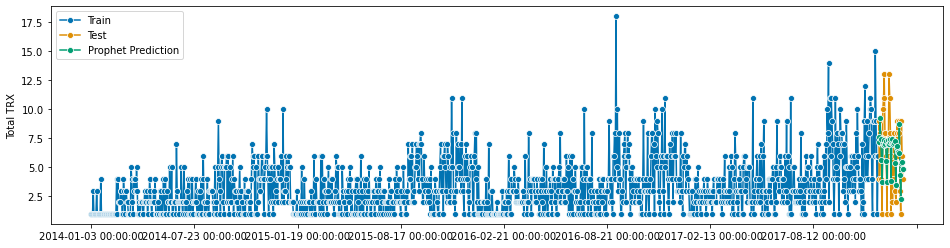

In [261]:
# plot the forecast trx
plot_series(y_train_trx, y_test_trx, y_pred_prophet_trx, labels=["Train", "Test","Prophet Prediction"]);

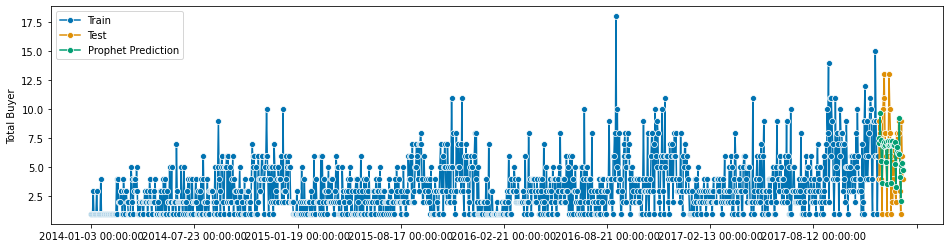

In [262]:
# plot the forecast buyer
plot_series(y_train_buyer, y_test_buyer, y_pred_prophet_buyer, labels=["Train", "Test","Prophet Prediction"]);

**Residuals**

In [263]:
residuals_prophet_trx = y_test_trx - y_pred_prophet_trx
residuals_prophet_buyer = y_test_buyer - y_pred_prophet_buyer

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

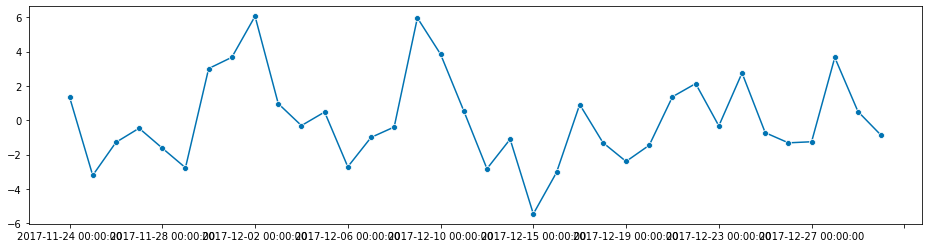

In [264]:
plot_series(residuals_prophet_trx)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

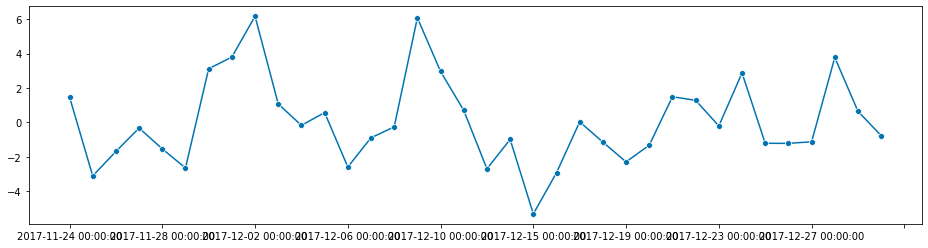

In [265]:
plot_series(residuals_prophet_buyer)

**Normality of Residuals**

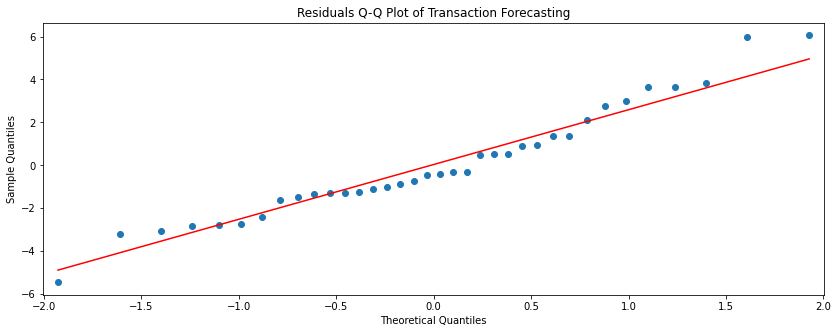

In [266]:
sm.qqplot(residuals_prophet_trx, line = 's').set_size_inches((14,5))
plt.title("Residuals Q-Q Plot of Transaction Forecasting")
plt.show()

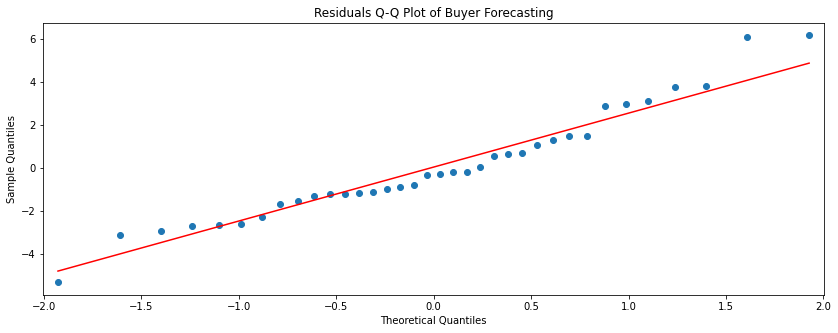

In [267]:
sm.qqplot(residuals_prophet_buyer, line = 's').set_size_inches((14,5))
plt.title("Residuals Q-Q Plot of Buyer Forecasting")
plt.show()

**Evaluation**

In [268]:
# Transaction Error Prediction
MAE = mean_absolute_error(y_test_trx, y_pred_prophet_trx)
MSE = mean_squared_error(y_test_trx, y_pred_prophet_trx)
RMSE = np.sqrt(MSE)
MAPE = mean_absolute_percentage_error(y_test_trx, y_pred_prophet_trx) * 100
pd.DataFrame([MAE, MSE, RMSE, MAPE], index=['MAE', 'MSE', 'RMSE','MAPE'], columns=['Metrics'])

In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.


Metrics
MAE    2.029781
MSE    6.521016
RMSE   2.553628
MAPE  38.506728

In [269]:
# Buyer Error Prediction
MAE = mean_absolute_error(y_test_trx, y_pred_prophet_buyer)
MSE = mean_squared_error(y_test_trx, y_pred_prophet_buyer)
RMSE = np.sqrt(MSE)
MAPE = mean_absolute_percentage_error(y_test_trx, y_pred_prophet_buyer) * 100
pd.DataFrame([MAE, MSE, RMSE, MAPE], index=['MAE', 'MSE', 'RMSE','MAPE'], columns=['Metrics'])

In the percentage error metric functions the default argument symmetric=True is changing to symmetric=False in v0.12.0.


Metrics
MAE    2.039200
MSE    6.604581
RMSE   2.569938
MAPE  38.372029

## Mean Absolute Percentage Error Comparison

In [279]:
arima_mape = 48.659518
ets_mape = 50.049103
autoets_mape = 48.504493
tbats_mape = 58.589925
prophet_mape = 38.372029

Text(0.5, 1.0, 'Plotting the Model Mean Absolute Percentage Errors')

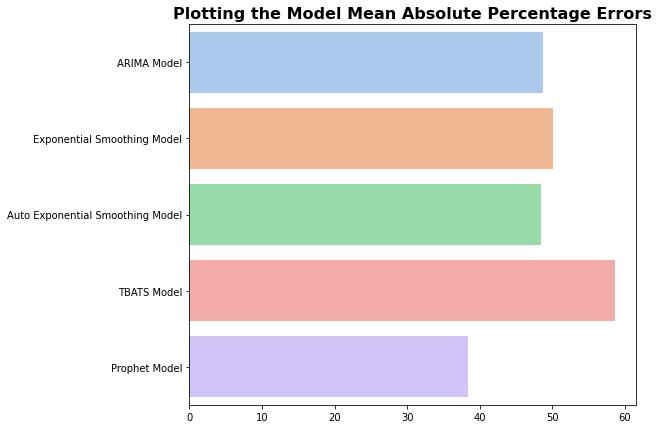

In [280]:
plt.figure(figsize= (8,7))
mapevalue = [arima_mape, ets_mape, autoets_mape, tbats_mape, prophet_mape]
modelname = ['ARIMA Model','Exponential Smoothing Model','Auto Exponential Smoothing Model','TBATS Model','Prophet Model']
sns.barplot(x = mapevalue,y = modelname,palette='pastel')
plt.title("Plotting the Model Mean Absolute Percentage Errors", fontsize=16, fontweight="bold")

The best model prediction is using **Prophet Model**. The **Prophet** models give us the smallest **Mean Absolute Percentage Errors**. Based on **[Facebook's page for Prophet](https://facebook.github.io/prophet/#:~:text=Prophet%20is%20a%20procedure%20for,several%20seasons%20of%20historical%20data.)** Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.